# Анализ данных

Что присутствует в данном ноутбуке:
* Долгое и нудное приведение данных из двух различных источников к единому формату
* Очистка этих данных от выбросов, опечаток и иных ошибок
* Генерация новых признаков для будущих моделей
* Построение визуализаций, проверка гипотез и расчет разнообразных статистик


## Библиотеки

In [1]:
# Стандартный стэк
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Работа с текстом
import nltk
from nltk import word_tokenize

# Дополнительные визуализации 
from wordcloud import WordCloud
from dython import nominal

# Проверка гипотез
import scipy

## Данные

На вход имеем 2 таблички с данными об объявлениях по продаже квартир.

In [2]:
av_data = pd.read_csv('data1_A.csv', index_col = 0)
data = pd.read_csv('data1_C.csv', index_col = 0)

## Функции и классы


In [3]:
### №1 Функция возвращает наиболее часто встречаемое значение в колонке to_find среди домов с тем же адресом, что и x
def find_something(x, to_find):
    if x.loc['number'] != '0': # Проводим поиск только для адресов с номером дома
        if data_full[(data_full.street == x.loc['street']) & (data_full.number == x.loc['number'])][to_find] \
        .dropna().empty == False: # Инициализируем поиск, только если есть дома с таким же адресом
            return(data_full[(data_full.street == x.loc['street']) & (data_full.number == x.loc['number'])][to_find] \
                   .dropna().value_counts().idxmax())
        else:
            return np.nan
    else:
        return np.nan

### №2 Так как часто придется рисовать много гистограмм, создадим функцию, принимающую на вход число столбцов и строк для \
### будущих подграфиков, данные, которые будем отрисовывать и часть стандартных для sns переменныхЮ рисующую в \
### зависимости от этих параметров три вида гистограмм
def multi_plot(n_cols, n_rows, plot_data, x, palette = 'tab10', figsize = (20,10), bins = 50, binwidth = None, \
               legend = False):
    fig, ax = plt.subplots(ncols=n_cols, nrows = n_rows, figsize = figsize)
    fig.tight_layout()
    sns.set_palette(palette)
    fig.subplots_adjust(top=0.95)
    i = 0
    j = 0
    if bins != 50:
        while True:
            sns.histplot(data = plot_data, x = x[j + n_cols*i], ax = ax[i, j], bins = bins_list[j+n_cols*i], \
                         legend = legend, multiple = 'stack', binwidth = binwidth)
            if j == (n_cols - 1) and i == (n_rows - 1):
                break
            elif j < (n_cols - 1):
                j = j + 1
            else:
                j = 0
                i = i + 1
    elif x.shape[0] > 3000:
        while True:
            sns.histplot(data = plot_data, x = x, ax = ax[i, j], bins = bins, 
                         legend = legend, hue = plot_data.columns[j + n_cols*i], binwidth = binwidth, multiple = 'stack')
            if j == (n_cols - 1) and i == (n_rows - 1):
                break
            elif j < (n_cols - 1):
                j = j + 1
            else:
                j = 0
                i = i + 1
    else:
        while True:
            sns.histplot(data = plot_data, x = x[j + n_cols*i], ax = ax[i, j], bins = bins, legend = legend, \
                         binwidth = binwidth, multiple = 'stack')
            if j == (n_cols - 1) and i == (n_rows - 1):
                break
            elif j < (n_cols - 1):
                j = j + 1
            else:
                j = 0
                i = i + 1

## Обработка данных

Начнем с объявлений из источника **A**, так как на первый взгляд данные оттуда легче привести к данным из **Ц**, чем наоборот, постепенно включая в процесс и последний сет. Первоначальные задачи: почистить опечатки (по возможности дополняя данные, а не удаляя их), упорядочить формат данных, чтобы затем привести обе таблички к стандартному виду и слить их в один фрейм.

**Аттрибутный состав данных**:

* *id* - идентификационный номер объявления объявления
* *price* - цена квартиры в рублях
* *floor* - этаж, на котором находится квартира
* *max_floor* - этажность дома, в котором находится квартира
* *year* - год постройки дома
* *type* - вторичка/первичка
* *total_square* - общая площадь квартиры
* *kitchen_square* - площадь кухни
* *living_square* - жилая площадь
* *planning* - тип планировки
* *rooms* - количество комнат
* *toilet* - количество туалетов и ванных комнат
* *view* - вид из окна
* *balcony* - количество балконов/лоджий
* *renovation* - ремонт в квартире
* *ceiling* - высота потолков
* *elevator* - количество лифтов в доме
* *parking* - вид парковки у дома
* *building* - тип перекрытий внутри дома
* *inside* - информация об удобствах внутри дома
* *court* - информация о дворе дома
* *additionally* - дополнительная информация о доме
* *source* - тип источника объявления о продаже
* *consultant* - риэлторское агенство, отвечающее за объявление
* *name* - информация о продавце
* *address* - адрес дома
* *description* - текстовое описание объявления

В табличке **Ц** также должны были быть данные о площади комнат и о том, является ли квартира апартаментами, но или в Абакане нет апартаментов и люди, выкладывающие объявления, не владеют информацией о площади комнат, или проблема произошла еще на этапе сбора данных.

In [4]:
av_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1662 entries, 0 to 1661
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1662 non-null   int64  
 1   price           1662 non-null   int64  
 2   floor           1661 non-null   float64
 3   max_floor       1661 non-null   float64
 4   year            1118 non-null   object 
 5   type            1658 non-null   object 
 6   total_square    1661 non-null   float64
 7   kitchen_square  1093 non-null   float64
 8   living_square   632 non-null    float64
 9   planning        995 non-null    object 
 10  rooms           1661 non-null   object 
 11  toilet          1348 non-null   object 
 12  view            1338 non-null   object 
 13  balcony         1613 non-null   object 
 14  renovation      1196 non-null   object 
 15  ceiling         739 non-null    float64
 16  elevator        1048 non-null   object 
 17  parking         1118 non-null   o

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2457 entries, 0 to 2456
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2457 non-null   int64  
 1   price           2457 non-null   int64  
 2   floor           2457 non-null   int64  
 3   max_floor       2457 non-null   int64  
 4   year            1964 non-null   float64
 5   type            2457 non-null   object 
 6   total_square    2457 non-null   float64
 7   kitchen_square  1316 non-null   float64
 8   living_square   610 non-null    float64
 9   room_square     0 non-null      float64
 10  planning        472 non-null    object 
 11  rooms           2457 non-null   object 
 12  toilet          1827 non-null   object 
 13  view            1034 non-null   object 
 14  balcony         1990 non-null   object 
 15  renovation      2013 non-null   object 
 16  ceiling         373 non-null    object 
 17  elevator        870 non-null    o

Сначала удалим повторяющиеся объявления и разберемся с недостающими адресами, вручную переходя по ссылкам и уточняя их. Так как большая часть уже сняты с продажи, придется от них избавиться.

In [6]:
av_data = av_data.drop_duplicates('id')
av_data.loc[282, 'address'] = 'Республика Хакасия, Абакан, ул. Некрасова, 45'
av_data.loc[740, 'address'] = 'Республика Хакасия, Абакан, Советская улица, 167'
av_data.loc[868, 'address'] = 'Республика Хакасия, Абакан, ул. Кирова, 206А'
av_data = av_data.drop(axis = 0, index = av_data[av_data.address.isnull()].index)

Приведем высоту потолков к одной размерности (часть указаны в сантиметрах, другие в метрах).

In [7]:
av_data.loc[av_data.ceiling > 200, 'ceiling'] = av_data.ceiling[av_data.ceiling > 200]/100
av_data.loc[av_data.ceiling > 20, 'ceiling'] = av_data.ceiling[av_data.ceiling > 20]/10
av_data.loc[av_data.ceiling > 10, 'ceiling'] = av_data.ceiling[av_data.ceiling > 10]/10
av_data.ceiling.value_counts()

2.70    187
2.50    131
2.80    126
2.60     55
3.00     46
2.90     33
2.00     11
3.30      5
2.40      4
3.10      3
3.20      2
2.75      2
3.50      2
2.20      1
2.67      1
2.10      1
3.40      1
2.85      1
1.60      1
1.70      1
2.71      1
2.30      1
2.65      1
4.70      1
4.00      1
1.90      1
1.40      1
Name: ceiling, dtype: int64

Посмотрим, что это за такие квартиры с потолками меньше двух метров и выше четырех.

In [8]:
av_data[(av_data.ceiling < 2) | (av_data.ceiling > 3.9)].id

276     2178487986
432     2088726093
523     2093514688
741     2047924899
1251    2175943261
1631    2186799843
Name: id, dtype: int64

В первых трех явные опечатки (в последней (барак с потолками 1.4 метра) очевидно раньше жили хоббиты). С 741 не все так ясно, не уверен, что бывают квартиры с потолками высотой 1.9 метра, да и по фотографиям там должно быть значительно выше. Есть еще пара квартир с потолками выше 3.9 метров, обе выполнены в виде двухэтажных студий. Пока не понятно, что с ними делать, оставим как есть.

Заполняем руками пропавшие этажи у 1382. По какой-то причине это объявление было добыто с ошибками, заполним его остальные поля вручную.

In [9]:
av_data.loc[1382, 'floor'] = 6
av_data.loc[1382, 'max_floor'] = 16

av_data.loc[1382, 'rooms'] = '3 '
av_data.loc[1382, 'planning'] = 'изолированные'
av_data.loc[1382, 'total_square'] = 84
av_data.loc[1382, 'ceiling'] = 3
av_data.loc[1382, 'renovation'] = 'косметический'
av_data.loc[1382, 'toilet'] = 'совмещенный'
av_data.loc[1382, 'balcony'] = 'лоджия'
av_data.loc[1382, 'view'] = 'во двор'
av_data.loc[1382, 'additionally'] = 'панорамные окна'
av_data.loc[1382, 'building'] = 'монолитный'
av_data.loc[1382, 'year'] = 2016
av_data.loc[1382, 'elevator'] = '1 pass 1 cargo'
av_data.loc[1382, 'parking'] = 'подземная, открытая во дворе'
av_data.loc[1382, 'court'] = 'закрытая территория, детская площадка, спортивная площадка'
av_data.loc[1382, 'inside'] ='консьерж, мусоропровод'

Воспользовавшись предположением о том, что полученные с авито объявления находятся на сайте с 2021 года, присвоим ячейкам со значениями *'сдан'* в качестве года постройки 2021, а также обновим жилплощадь, которой в этом году исполнилось 2020, и вернем в прошлое квартиру из 1910000 года.

In [10]:
av_data = av_data.replace({'year': {'2 кв. 2022 года':'2022', '4 кв. 2021 года':'2021', '4 кв. 2022 года':'2022',
                         '3 кв. 2022 года':'2022', '3 кв. 2024 года':'2024', 'сдан':'2021', '1910000':'1950', '1':'1981'}})
av_data.year = pd.to_numeric(av_data.year)

Доопределяем вторички/новостройки. Перебираем и вручную заполняем исчезнувший тип продаваемой квартиры. У 66-го объявления по неведомой причине с актуальным объявлением не совпадают практически никакие данные кроме цены (единственными логическими объяснениями вижу редактирование объявления/фантастическую смену id).

In [11]:
av_data.loc[740, 'type'] = 'Вторичка'
av_data.loc[769, 'type'] = 'Вторичка'
av_data.loc[1021, 'type'] = 'Вторичка'
av_data.loc[66, 'type'] = 'Вторичка'
av_data.loc[66, 'floor'] = 3
av_data.loc[66, 'max_floor'] = 10
av_data.loc[66, 'balcony'] = 'лоджия'
av_data.loc[66, 'rooms'] = 'студия '
av_data.loc[66, 'total_square'] = 23
av_data.loc[66, 'kitchen_square'] = np.nan
av_data.loc[66, 'toilet'] = 'совмещенный'
av_data.loc[66, 'elevator'] = '1 cargo'
av_data.loc[66, 'parking'] = np.nan
av_data.loc[66, 'court'] = 'детская площадка'
av_data.loc[66, 'additionally'] = np.nan
av_data.loc[66, 'ceiling'] = np.nan
av_data.loc[66, 'consultant'] = 'Частное лицо'
av_data.loc[66, 'planning'] = np.nan

Есть одна чрезвычайно подозрительная квартира с площадью кухни 54.6 м² и жилой площадью 8.4 м² Поменяем для правдоподобности, фотографии на сайте тоже говорят об обратном.

In [12]:
av_data.loc[av_data[av_data.kitchen_square > 40].index, 'kitchen_square'] = 8.4
av_data.loc[av_data[av_data.kitchen_square > 40].index, 'living_square'] = 54.6

### Теперь будем работать одновременно и с **А**, и с **Ц**.

Переобозначим информацию о комнатах так, чтобы маркировки были идентичны для данных с обоих источников. Здесь и далее для квартир, в которых не указано число комнат, используются следующие маркировки:
* **С** для студий
* **К** для квартир свободной планировки
* **М** для многокомнатных квартир

*Примечание: только спустя много строк кода до меня дошло, что каждая из этих букв есть как в английском, так и в русском алфавитах. Везде в коде, в том числе при операциях сравнения, используются эти буквы из последнего (конечно, надо было бы поменять, но не хочется лишний раз ломать то, что работает).*

In [13]:
av_data.loc[av_data.rooms == 'студия ', 'rooms'] = 'С'
av_data.loc[av_data.rooms == 'своб. планировка ', 'rooms'] = 'К'
av_data.loc[(av_data.rooms != 'С') & (av_data.rooms != 'К'), 'rooms'] = \
av_data.loc[(av_data.rooms != 'С') & (av_data.rooms != 'К'), 'rooms'].astype(np.int64)

data.loc[(data.rooms != 'С') & (data.rooms != 'К') & (data.rooms != 'М'), 'rooms'] = \
data.loc[(data.rooms != 'С') & (data.rooms != 'К') & (data.rooms != 'М'), 'rooms'].astype(np.int64)

Продолжаем колдовать со значениями в столбцах, на очереди типажи домов, планировки и вид из окон.

In [14]:
av_data.loc[av_data.type == 'Новостройки', 'type'] = 'Новостройка'

av_data.loc[av_data.planning == 'изолированные', 'planning'] = 'Изолированная'
av_data.loc[av_data.planning == 'смежные', 'planning'] = 'Смежная'
av_data.loc[av_data.planning == 'смежные, изолированные', 'planning'] = 'Смежно-изолированная'

av_data.loc[av_data.view == 'во двор, на улицу', 'view'] = 'На улицу и двор'
av_data.loc[av_data.view == 'на улицу, во двор', 'view'] = 'На улицу и двор'
av_data.loc[av_data.view == 'во двор', 'view'] = 'Во двор'
av_data.loc[av_data.view == 'на улицу', 'view'] = 'На улицу'

data.loc[data.toilet == '1 раздельный', 'toilet'] = 'раздельный'
data.loc[data.toilet == '1 совмещенный', 'toilet'] = 'совмещенный'
data.loc[data.toilet == '2 раздельных', 'toilet'] = 'совмещенный'
data.loc[data.toilet == '2 совмещенных', 'toilet'] = 'совмещенный'
data.loc[data.toilet == '1 совмещенный, 1 раздельный', 'toilet'] = 'несколько'
data.loc[data.toilet == '1 совмещенный, 4 раздельных', 'toilet'] = 'несколько'
data.loc[data.toilet == '1 совмещенный, 2 раздельных', 'toilet'] = 'несколько'

Предположим, что если в объявлении не указано наличие *балкона/лоджии*, то их в квартире и нет (кажется логичным, что если в квартире есть хотя бы одно из перечисленных, то адекватный рекламодатель указал бы их в описании), чиним еще часть столбцов, избавляемся от пустых *apartment* и *room_square*.

In [15]:
av_data.loc[av_data.balcony == 'балкон', 'balcony'] = '1 балкон'
av_data.loc[av_data.balcony == 'лоджия', 'balcony'] = '1 лоджия'
data.loc[data.balcony.isnull(), 'balcony'] = 'нет'
av_data.loc[av_data.balcony.isnull(), 'balcony'] = 'нет'

av_data.loc[av_data.renovation == ('косметический'), 'renovation'] = 'Косметический'
av_data.loc[av_data.renovation == ('евро'), 'renovation'] = 'Евроремонт'
av_data.loc[av_data.renovation == ('дизайнерский'), 'renovation'] = 'Дизайнерский'
av_data.loc[av_data.renovation == ('черновая'), 'renovation'] = 'Без ремонта'
av_data.loc[av_data.renovation == ('требует ремонта'), 'renovation'] = 'Без ремонта'
av_data.loc[av_data.renovation == ('без отделки'), 'renovation'] = 'Без ремонта'
av_data.loc[av_data.renovation == ('чистовая'), 'renovation'] = 'Косметический'

data.loc[data.ceiling.notnull(), 'ceiling'] = \
data.loc[data.ceiling.notnull(), 'ceiling'].apply(lambda x: np.float64(x.split(' ')[0].replace(',', '.')))
data.loc[data.ceiling > 20, 'ceiling'] = data.loc[data.ceiling > 20, 'ceiling']/10


data.loc[:, 'building'] = data.building.str.lower()
data = data.drop(axis = 1, columns = ['apartment', 'room_square'])

av_data.loc[:, 'source'] = av_data.source.replace(['\n\n', '\n \n'], '', regex=True)
av_data.loc[av_data.consultant == 'Агентство', 'consultant'] = av_data.loc[av_data.consultant == 'Агентство', 'source']

В выборку с авито попали объявления из Минусинска (Красноярский край), которые нас не интересуют, избавимся от них.

In [16]:
av_data = av_data.drop(av_data[av_data.address.str.contains('край')].index, axis = 0)

Немного (много) индусского кода, отделяющего собственников от риэлторов. Будем считать риэлторов с числом объявлений менее 5 за собственников.

In [17]:
av_data.loc[av_data.consultant == 'Частное лицо', 'consultant'] = 'Собственник'
av_data.loc[av_data.consultant.str.lower().str.contains('собств') == True, 'consultant'] = 'Собственник'
av_data.loc[av_data.consultant.str.lower().str.contains('ксен|елен|ольг|натал|светл|серг|наст|лекс|ларис|марин') == \
            True, 'consultant'] = 'Собственник' # Избавимся от Ксений, Елен, Ольг, Сергеев и прочих в именах

av_data.loc[av_data.consultant.str.lower().str.contains('лидер') == True, 'consultant'] = 'Лидер'
av_data.loc[av_data.consultant.str.lower().str.contains('эверест') == True, 'consultant'] = 'Эверест'
av_data.loc[av_data.consultant.str.lower().str.contains('жилфонд') == True, 'consultant'] = 'Жилфонд'
av_data.loc[av_data.consultant.str.lower().str.contains('этажи') == True, 'consultant'] = 'Этажи'
av_data.loc[av_data.consultant.str.lower().str.contains('глобус') == True, 'consultant'] = 'Глобус'
av_data.loc[av_data.consultant.str.lower().str.contains('советск') == True, 'consultant'] = 'На советской'
av_data.loc[av_data.consultant.str.lower().str.contains('удачн') == True, 'consultant'] = 'Удачный дом'
av_data.loc[av_data.consultant.str.lower().str.contains('шаг') == True, 'consultant'] = 'Шаг'
av_data.loc[av_data.consultant.str.lower().str.contains('ваш') == True, 'consultant'] = 'Ваш риэлтор'
av_data.loc[av_data.consultant.str.lower().str.contains('брокер') == True, 'consultant'] = 'Брокер плюс'
av_data.loc[av_data.consultant.str.lower().str.contains('квартал') == True, 'consultant'] = 'Квартал'
av_data.loc[av_data.consultant.str.lower().str.contains('глор') == True, 'consultant'] = 'Глорис'
av_data.loc[av_data.consultant.str.lower().str.contains('квадр') == True, 'consultant'] = 'Квадратный метр'
av_data.loc[av_data.consultant.str.lower().str.contains('метраж') == True, 'consultant'] = 'Метражи'
av_data.loc[av_data.consultant.str.lower().str.contains('компас') == True, 'consultant'] = 'Компас'
av_data.loc[av_data.consultant.str.lower().str.contains('южн') == True, 'consultant'] = 'Южно-сибирское'
av_data.loc[av_data.consultant.str.lower().str.contains('а1 ') == True, 'consultant'] = 'А1'
av_data.loc[av_data.consultant.str.lower().str.contains('респ') == True, 'consultant'] = 'Республика(агентство)'
av_data.loc[av_data.consultant.str.lower().str.contains('этик') == True, 'consultant'] = 'Этика'

data.loc[data.consultant.str.lower().str.contains('южн') == True, 'consultant'] = 'Южно-сибирское'
data.loc[data.consultant.str.lower().str.contains('собств') == True, 'consultant'] = 'Собственник'
data.loc[data.consultant.str.lower().str.contains('лидер') == True, 'consultant'] = 'Лидер'
data.loc[data.consultant.str.lower().str.contains('эверест') == True, 'consultant'] = 'Эверест'
data.loc[data.consultant.str.lower().str.contains('жилфонд') == True, 'consultant'] = 'Жилфонд'
data.loc[data.consultant.str.lower().str.contains('этажи') == True, 'consultant'] = 'Этажи'
data.loc[data.consultant.str.lower().str.contains('глобус') == True, 'consultant'] = 'Глобус'
data.loc[data.consultant.str.lower().str.contains('советск') == True, 'consultant'] = 'На советской'
data.loc[data.consultant.str.lower().str.contains('удачн') == True, 'consultant'] = 'Удачный дом'
data.loc[data.consultant.str.lower().str.contains('шаг') == True, 'consultant'] = 'Шаг'
data.loc[data.consultant.str.lower().str.contains('ваш') == True, 'consultant'] = 'Ваш риэлтор'
data.loc[data.consultant.str.lower().str.contains('брокер') == True, 'consultant'] = 'Брокер плюс'
data.loc[data.consultant.str.lower().str.contains('квартал') == True, 'consultant'] = 'Квартал'
data.loc[data.consultant.str.lower().str.contains('глор') == True, 'consultant'] = 'Глорис'
data.loc[data.consultant.str.lower().str.contains('квадр') == True, 'consultant'] = 'Квадратный метр'
data.loc[data.consultant.str.lower().str.contains('метраж') == True, 'consultant'] = 'Метражи'
data.loc[data.consultant.str.lower().str.contains('компас') == True, 'consultant'] = 'Компас'
data.loc[data.consultant.str.lower().str.contains('южн') == True, 'consultant'] = 'Южно-сибирское'
data.loc[data.consultant.str.lower().str.contains('а1 ') == True, 'consultant'] = 'А1'

losers = av_data.consultant.value_counts()
for los in range(0, sum(losers <= 4)):
    av_data.loc[av_data.consultant == losers[losers <= 4].index.tolist()[los], 'consultant'] = 'Собственник'

Логика с парковками следующая. Если есть *подземная*, то ее и укажем, как наиболее приоритетную. *За шлагбаумом/многоуровневая* пусть идут как *наземные* (с предположением о том, что они не *открытые*), остальные остаются как есть. Приходится придумывать, как объединять значения, которые сильно отличаются у **Ц** и **А** при том, что самих данных о парковках чрезвычайно мало. Итого получаются следующие категории: *открытая во дворе*, *наземная*, *подземная*, *открытая*.

In [18]:
av_data.loc[av_data.parking.str.lower().str.contains('подземн') == True, 'parking'] = 'Подземная'
av_data.loc[av_data.parking.str.lower().str.contains('наземн|шлагб') == True, 'parking'] = 'Наземная'

Лифтинг. Здесь из-за большого числа пропусков и различий в описаниях проще разделить на следующие категории: *Есть* (лифт), *Нет*, *Есть грузовой*.

In [19]:
av_data.loc[av_data.elevator == '0 pass 0 cargo', 'elevator'] = 'Нет'
av_data.loc[av_data.elevator == '0 pass ', 'elevator'] = 'Нет'
av_data.loc[av_data.elevator == 'nan0 cargo', 'elevator'] = 'Нет'
av_data.loc[av_data.elevator.str.lower().str.contains('nan') == True, 'elevator'] = \
av_data.loc[av_data.elevator.str.lower().str.contains('nan') == True, 'elevator'].map(lambda x: x[3:])
av_data.loc[av_data.elevator == '0 pass 1 cargo', 'elevator'] = 'Есть грузовой'
av_data.loc[av_data.elevator.str.contains('carg') == True, 'elevator'] = 'Есть грузовой'
av_data.loc[av_data.elevator.str.contains('pass') == True, 'elevator'] = 'Есть'

data.loc[data.elevator.str.contains('пасс|все') == True, 'elevator'] = 'Есть'
data.loc[data.elevator.str.contains('груз.', regex = False) == True, 'elevator'] = 'Есть'

Приведем адреса к упорядоченному виду, чтобы позднее с их помощью определять повторяющиеся объявления на разных площадках:
разделяем адрес на **улицу** и **номер дома**. Первым делом приводим адрес в нижний регистр.

Сначала разберемся с номерами домов. Здесь несколько проблем: во-первых, часть адресов разделена по корпусам, эти корпуса могут обозначаться в адресе как, например, 'д.10к4', 'д.10корп.4', 'д.10/4' (здесь приведем к единому виду - последнему из указанных, то есть через '/'); следом за этим определенное число адресов имеет перед номером дома 'д.', это добавку выкинем за ненадобностью; ну и естественно появляются попорченные/недозаполненные адреса, номера дома в которых нет вообще, для них в качестве номера поставим '0'. 

Затем переходим к названиям улиц. Избавляемся от республики и города в адресе, а также от окружающих наименование улицы ненужных атрибутов (улица/проспект/микрорайон и т.д.).

In [20]:
### А
av_ad = pd.DataFrame(av_data.address.str.lower())
av_ad['spl_n'] = np.nan
av_ad['spl_slash'] = np.nan

av_ad.spl_n = av_ad.address.apply(lambda x: x.split(',')[-1].replace(' ', '') if (('корп' in x) == False) else np.nan)

# Костыль с replace из-за разницы .str.split() и .split() для string
av_ad.spl_slash = av_ad.address.apply(lambda x: (x.replace('.', ',').split(',')[-3] + '/' + x.replace('.', ',') \
                                                 .split(',')[-1]).replace(' ', '') if ('корп.' in x) else np.nan)

av_ad.loc[av_ad.spl_n.isnull(), 'spl_n'] = av_ad.loc[av_ad.spl_n.isnull(), 'spl_slash']
av_ad.loc[:, 'spl_n'] = av_ad.spl_n.apply(lambda x: x.replace('к', '/') if ('к' in x) else x)
av_ad.loc[:, 'spl_n'] = av_ad.spl_n.apply(lambda x: x.replace('д.', '') if ('д' in x) else x)
av_ad.loc[:, 'spl_n'] = av_ad.spl_n.apply(lambda x: '0' if (len(x) > 8) else x)
av_ad = av_ad.drop('spl_slash', axis = 1)

crap_dict = dict.fromkeys(['республика хакасия, ', 'улица ', 'абакан, ', 'проспект ', 'микрорайон нижняя согра, ', \
                           'микрорайон, ', 'микрорайон верхняя согра, ', 'микрорайон ', 'нижняя согра, ', \
                           'верхняя согра, ', 'пр-т ', 'пр-т', 'ул. ', 'пр. ', 'пр.', 'ул.', ' ца', 'ца', \
                           'хакасия респ., ', 'езд', ' езд', 'сп. ', 'нижняя согра ', ' микрорайон', ' '], '')

av_ad.address = av_ad.address.replace(crap_dict, regex = True)
av_ad['street'] = av_ad.address.apply(lambda x: x.split(',')[0].replace(' ', ''))

# Остаются два мусорных адреса, скорее всего, подверженные опечаткам, избавляемся от них
av_ad = av_ad.drop(av_ad[av_ad.address.str.contains('железн|согра')].index, axis = 0)

### Ц
# Как показала практика, будет удобнее, если сразу почистить адрес от ненужных атрибутов
ad = pd.DataFrame(data.address.str.lower())
ad.address = ad.address.replace(crap_dict, regex = True)

ad['street'] = ad.address.apply(lambda x: x.split(',')[0])
ad['number'] = ad.address.apply(lambda x: x.split(',')[1] if (len(x.split(',')) > 1) else '0')

# Опечатка
ad.loc[ad.number == 'зеленая', 'street'] = 'зеленая'
ad.loc[ad.number == 'зеленая', 'number'] = '0'

# Здесь придется быть аккуратнее с корпусами, так как есть дома с буквой к и в номере дома, и к в качестве корпуса: '74кк4'
ad.number = ad.number.apply(lambda x: x.replace('к', '/') if ('к' in x and ('кк' in x) == False) else x)
ad.loc[ad.number.str.contains('кк'), 'number'] = ad[ad.number.str.contains('кк')].number.str.replace('кк', 'к/')

# Возвращаемся к исходным фреймам
data['street'] = ad.street
data['number'] = ad.number
av_data['street'] = av_ad.street
av_data['number'] = av_ad.spl_n
av_data = av_data.drop(index = [977, 1379], axis = 0)
data = data.rename({'id':'id_c'}, axis=1)
av_data = av_data.rename({'id':'id_a'}, axis=1)

# Убираем ё
data.street = data.street.replace('ё', 'е', regex = True)
av_data.street = av_data.street.replace('ё', 'е', regex = True)

# Небольшая правка в улице, чтобы привести к одному виду 'молодежныйквартал' и 'кварталмолодежный' и пара опечаток
data.loc[data.street.str.contains('квартал'), 'street'] = 'молодежныйквартал'
av_data.loc[av_data.street.str.contains('квартал'), 'street'] = 'молодежныйквартал'
data.street = data.street.replace('нижняясогра|верхняясогра', '', regex = True)
av_data.street = av_data.street.replace('нижняясогра|верхняясогра', '', regex = True)
data.street = data.street.replace('арбан18', 'арбан', regex = True)
av_data.street = av_data.street.replace('арбан18', 'арбан', regex = True)

### Объединение таблиц

Немного о том, зачем нужны были все эти танцы с бубном. Очевидно, что существуют объявления о продаже одной и той же квартире, размещенные и на **Ц**, и на **А**. Их поиск представляет собой определенную трудность, так как приходится одновременно сравнивать *цену*, *этаж*, *максимальный этаж* в доме, *общую площадь* и *количество комнат*, чтобы как можно точнее определить одинаковые объявления. 

Если не использовать хотя бы один из этих показателей, то в качестве совпадающих объявлений находятся очень близкие друг к другу по описанным параметрам квартиры, отличие которых легко заметить по их адресу. Однако большего числа признаков, доступных для *каждого* наблюдения, просто нет, остальные данные слишком разряжены для сравнения, к тому же возникает мысль о том, что цена - не совсем корректный параметр поиска совпадений, так как для одной и той же квартиры она может отличаться, например, из-за различий в дате публикации/опечаток/иных (может быть и намеренных) действий пользователей. 

Кроме того, количество одинаковых объявлений, найденных по всем описанным критериям, не более 30, что мне кажется каким-то бредом (совсем не верится, что среди ~2500 квартир с одной платформы и ~1500 с другой совпадают лишь 30 штук). В связи со всем вышеописанным и требуются приведенные к одному формату адреса, с помощью которых сейчас постараемся найти совпадающие объявления.

In [21]:
%%time
# В same будем складывать сопвадающиие объявления
same = np.zeros((0,2))

# Все описанное можно сделать без цикла через метод duplicated(), если бы нас удовлетворяли только точные совпадения цены
for i in data.index:
    for j in av_data.index:
        if (np.abs(data.loc[i, 'price'] - av_data.loc[j, 'price']) < 10**5 and # Можно потестировать и большую разность
            data.loc[i, 'street'] == av_data.loc[j, 'street'] and # Требуем хотя бы того, чтобы из адреса совпадала улица
            data.loc[i, 'floor'] == av_data.loc[j, 'floor'] and
            data.loc[i, 'max_floor'] == av_data.loc[j, 'max_floor'] and
            data.loc[i, 'rooms'] == av_data.loc[j, 'rooms'] and
            data.loc[i, 'total_square'] == av_data.loc[j, 'total_square']):
                same = np.append(same, np.array([[data.loc[i, 'id_c'], av_data.loc[j, 'id_a']]]), axis = 0)

# И долгожданное объединение
data_full = data.append(av_data[av_data.id_a.isin(list(map(int, same[:,1].tolist()))) == False], \
                        sort = False).reset_index(drop = True)
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3402 entries, 0 to 3401
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_c            2457 non-null   float64
 1   price           3402 non-null   int64  
 2   floor           3402 non-null   float64
 3   max_floor       3402 non-null   float64
 4   year            2556 non-null   float64
 5   type            3402 non-null   object 
 6   total_square    3402 non-null   float64
 7   kitchen_square  1945 non-null   float64
 8   living_square   949 non-null    float64
 9   planning        1026 non-null   object 
 10  rooms           3402 non-null   object 
 11  toilet          2601 non-null   object 
 12  view            1812 non-null   object 
 13  balcony         3402 non-null   object 
 14  renovation      2718 non-null   object 
 15  ceiling         785 non-null    object 
 16  elevator        1464 non-null   object 
 17  building        2500 non-null   o

Теперь те объявления, которые мы отобрали по схожести. Большую часть данных для них будем брать с авито (судя по нескольким примерам, там, как правило, более актуальная информация о доме). Цене присваиваем среднее.

In [22]:
%%time
for i in same:    
    data_full.loc[data_full.id_c == np.int64(i[0]), 'price'] = \
    (data_full.loc[data_full.id_c == np.int64(i[0]), 'price'].item() + \
     av_data.loc[av_data.id_a == np.int64(i[1]), 'price'].item())/2
    
    if av_data.loc[av_data.id_a == np.int64(i[1]), 'year'].notnull().item():
        data_full.loc[data_full.id_c == np.int64(i[0]), 'year'] = \
        av_data.loc[av_data.id_a == np.int64(i[1]), 'year'].item()
        
    if av_data.loc[av_data.id_a == np.int64(i[1]), 'kitchen_square'].notnull().item():
        data_full.loc[data_full.id_c == np.int64(i[0]), 'kitchen_square'] = \
        av_data.loc[av_data.id_a == np.int64(i[1]), 'kitchen_square'].item()
        
    data_full.loc[data_full.id_c == np.int64(i[0]), 'max_floor'] = \
    av_data.loc[av_data.id_a == np.int64(i[1]), 'max_floor'].item()
    
    if av_data.loc[av_data.id_a == np.int64(i[1]), 'living_square'].notnull().item():
        data_full.loc[data_full.id_c == np.int64(i[0]), 'living_square'] = \
        av_data.loc[av_data.id_a == np.int64(i[1]), 'living_square'].item()
        
    if av_data.loc[av_data.id_a == np.int64(i[1]), 'planning'].notnull().item():
        data_full.loc[data_full.id_c == np.int64(i[0]), 'planning'] = \
        av_data.loc[av_data.id_a == np.int64(i[1]),'planning'].item()
        
    if av_data.loc[av_data.id_a == np.int64(i[1]), 'toilet'].notnull().item():
        data_full.loc[data_full.id_c == np.int64(i[0]), 'toilet'] = \
        av_data.loc[av_data.id_a == np.int64(i[1]), 'toilet'].item()
        
    if av_data.loc[av_data.id_a == np.int64(i[1]), 'view'].notnull().item():
        data_full.loc[data_full.id_c == np.int64(i[0]), 'view'] = \
        av_data.loc[av_data.id_a == np.int64(i[1]), 'view'].item()
        
    if av_data.loc[av_data.id_a == np.int64(i[1]), 'renovation'].notnull().item():
        data_full.loc[data_full.id_c == np.int64(i[0]), 'renovation'] = \
        av_data.loc[av_data.id_a == np.int64(i[1]), 'renovation'].item()
        
    if av_data.loc[av_data.id_a == np.int64(i[1]), 'ceiling'].notnull().item():
        data_full.loc[data_full.id_c == np.int64(i[0]), 'ceiling'] = \
        av_data.loc[av_data.id_a == np.int64(i[1]), 'ceiling'].item()
        
    if av_data.loc[av_data.id_a == np.int64(i[1]), 'elevator'].notnull().item():
        data_full.loc[data_full.id_c == np.int64(i[0]), 'elevator'] = \
        av_data.loc[av_data.id_a == np.int64(i[1]), 'elevator'].item()
        
    if av_data.loc[av_data.id_a == np.int64(i[1]), 'building'].notnull().item():
        data_full.loc[data_full.id_c == np.int64(i[0]), 'building'] = \
        av_data.loc[av_data.id_a == np.int64(i[1]), 'building'].item()
        
    if av_data.loc[av_data.id_a == np.int64(i[1]), 'inside'].notnull().item():
        data_full.loc[data_full.id_c == np.int64(i[0]), 'inside'] = \
        (str(data_full.loc[data_full.id_c == np.int64(i[0]), 'inside']) + \
         str(av_data.loc[av_data.id_a == np.int64(i[1]), 'inside'].item()))
        
    data_full.loc[data_full.id_c == np.int64(i[0]), 'court'] = \
    av_data.loc[av_data.id_a == np.int64(i[1]), 'court'].item()
    
    if av_data.loc[av_data.id_a == np.int64(i[1]), 'parking'].notnull().item():
        data_full.loc[data_full.id_c == np.int64(i[0]), 'parking'] = \
        av_data.loc[av_data.id_a == np.int64(i[1]), 'parking'].item()
        
    if data_full.loc[data_full.id_c == np.int64(i[0]), 'consultant'].isnull().item():
        data_full.loc[data_full.id_c == np.int64(i[0]), 'consultant'] = \
        av_data.loc[av_data.id_a == np.int64(i[1]), 'consultant'].item()
        
    data_full.loc[data_full.id_c == np.int64(i[0]), 'id_a'] = np.int64(i[1].item())
    
    if data_full.loc[data_full.id_c == np.int64(i[0]), 'court'].isnull().item():
        data_full.loc[data_full.id_c == np.int64(i[0]), 'court'] = \
        av_data.loc[av_data.id_a == np.int64(i[1]), 'court'].item()
        
    data_full.loc[data_full.id_c == np.int64(i[0]), 'additionally'] = \
    (str(data_full.loc[data_full.id_c == np.int64(i[0]), 'additionally'].item()) + \
     str(av_data.loc[av_data.id_a == np.int64(i[1]), 'additionally'].item()))
    
    data_full.loc[data_full.id_c == np.int64(i[0]), 'description'] = \
    (str(data_full.loc[data_full.id_c == np.int64(i[0]), 'description'].item()) + 'avito: ' + \
     str(av_data.loc[av_data.id_a == np.int64(i[1]), 'description'].item()))

Wall time: 11.3 s


Помог ли этот гигантский кусок индусского кода длительностью в 11 секунд улучшить данные в выборке? Честно говоря, не очень (для большинства переменных удалось заполнить чуть больше ~100 пропусков), но попробовать стоило.

In [23]:
data_full = data_full.drop_duplicates(subset = ['floor', 'max_floor', 'price', 'street', 'number', 'rooms', 'type', \
                                                'balcony', 'consultant'])
data_full = data_full.drop(['source'], axis = 1)
data_full = data_full.reset_index(drop=True)
data_full.loc[data_full.type.str.contains('Вторичка'), 'type'] = 'Вторичка'
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3313 entries, 0 to 3312
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_c            2407 non-null   float64
 1   price           3313 non-null   float64
 2   floor           3313 non-null   float64
 3   max_floor       3313 non-null   float64
 4   year            2564 non-null   float64
 5   type            3313 non-null   object 
 6   total_square    3313 non-null   float64
 7   kitchen_square  2021 non-null   float64
 8   living_square   1031 non-null   float64
 9   planning        1293 non-null   object 
 10  rooms           3313 non-null   object 
 11  toilet          2644 non-null   object 
 12  view            2052 non-null   object 
 13  balcony         3313 non-null   object 
 14  renovation      2713 non-null   object 
 15  ceiling         960 non-null    object 
 16  elevator        1667 non-null   object 
 17  building        2616 non-null   o

### Финальная предобработка

Присутствует некое объявление с ценой в рекордные для Абакана ~35 млн. руб., взглянем на него поближе.

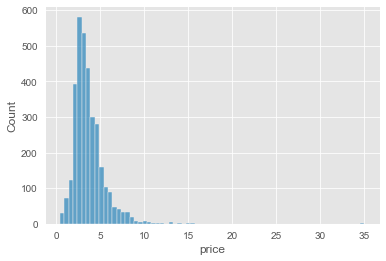

In [24]:
sns.set_palette("tab10")
sns.set_style('darkgrid')
plt.style.use('ggplot')

sns.histplot(data_full.price/10**6, bins = 70);

Все 4 выглядят очень подозрительно, но описания совпадают только у первых двух, а опечатка в цене только в третьем.

In [25]:
data_full.loc[(data_full.street == data_full.loc[data_full.price>20*(10**6), 'street'].values[0]) & \
              (data_full.number == data_full.loc[data_full.price>20*(10**6), 'number'].values[0])]

id_c       price  floor  max_floor    year      type  total_square  \
86  259732882.0   3580000.0    3.0        5.0  2000.0  Вторичка          52.0   
87  258822369.0   3500000.0    3.0        5.0  1998.0  Вторичка          50.0   
88  257280796.0  35000000.0    3.0        5.0  1998.0  Вторичка          51.0   
89  256193043.0   3500000.0    3.0        5.0  1998.0  Вторичка          51.0   

    kitchen_square  living_square       planning  ...            parking  \
86             9.0            NaN  Изолированная  ...  открытая во дворе   
87             9.0            NaN  Изолированная  ...                NaN   
88             8.0            NaN  Изолированная  ...                NaN   
89             NaN            NaN  Изолированная  ...                NaN   

     consultant                     name  \
86  Собственник  2-комн. квартира, 52 м²   
87  Собственник  2-комн. квартира, 50 м²   
88  Собственник  2-комн. квартира, 51 м²   
89  Собственник  2-комн. квартира, 51 м²   

                                      address  \
86  Хакасия респ., Абакан, Аскизская ул., 218   
87  Хакасия респ., Абакан, Аскизская ул., 218   
88  Хакасия респ., Абакан, Аскизская ул., 218   
89  Хакасия респ., Абакан, Аскизская ул., 218   

                                          description     street number  \
86  Квартира в добротном кирпичном доме на среднем...  аскизская    218   
87  Квартира в добротном кирпичном доме на среднем...  аскизская    218   
88  Отличная теплая квартира, окна пластик, лоджия...  аскизская    218   
89  Комнаты на разные стороны, окна пластик, замен...  аскизская    218   

            id_a                                  court additionally  
86  2.153591e+09  детская площадка, спортивная площадка       nannan  
87           NaN                                    NaN          NaN  
88           NaN                                    NaN          NaN  
89           NaN                                    NaN          NaN  

[4 rows x 30 columns]

In [26]:
data_full = data_full.drop([87, 88], axis = 0)

Взглянем на график снова - уже лучше.

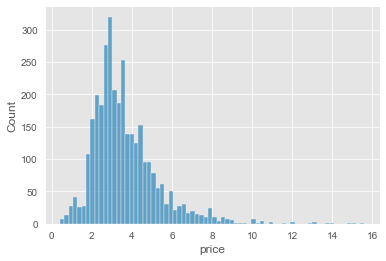

In [27]:
sns.histplot(data_full.price/10**6, bins = 70);

С этажами, судя по гистограммам, проблем нет. Бросается в глаза большое число пятиэтажек и девятиэтажек, в целом характерных для небольших городов.

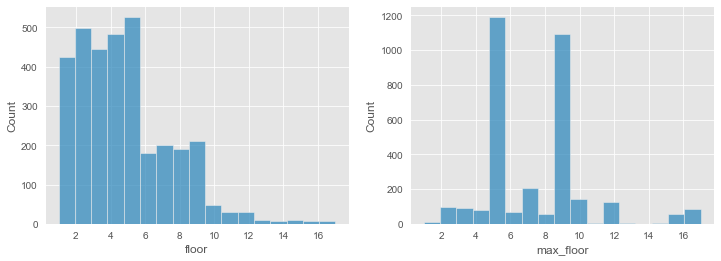

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
sns.histplot(data_full.floor, bins = 17, ax = ax[0]);
sns.histplot(data_full.max_floor, bins = 17, ax = ax[1]);

Судя по всему, в городе есть остатки древних руин, посмотрим, что же это за дома.

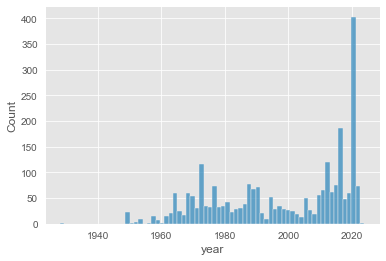

In [29]:
sns.histplot(data_full.year, bins = 70);

In [30]:
data_full[data_full.year < 1950]

id_c      price  floor  max_floor    year      type  \
155   258066090.0  4450000.0    1.0       10.0  1928.0  Вторичка   
156   258483129.0  4550000.0    7.0       10.0  1928.0  Вторичка   
1045  257223935.0  2220000.0    9.0       17.0  1949.0  Вторичка   
1048  258421009.0  2160000.0   13.0       17.0  1949.0  Вторичка   
1049  258148532.0  2260000.0    3.0       17.0  1949.0  Вторичка   
1050  253678815.0  4370000.0   17.0       17.0  1949.0  Вторичка   
1051  258413002.0  2530000.0   15.0       17.0  1949.0  Вторичка   
1052  259659240.0  2530000.0   15.0       17.0  1949.0  Вторичка   
1053  257311175.0  2530000.0    7.0       17.0  1949.0  Вторичка   
1054  256417454.0  3100000.0   10.0       17.0  1949.0  Вторичка   
1055  260648261.0  3370000.0    8.0       17.0  1949.0  Вторичка   
1056  245807494.0  2500000.0   14.0       17.0  1949.0  Вторичка   
1057  257799128.0  2530000.0   15.0       17.0  1949.0  Вторичка   
1058  240423502.0  4350000.0    5.0       17.0  1949.0  Вторичка   
1062  258412806.0  2530000.0   13.0       17.0  1949.0  Вторичка   
1063  254367848.0  2150000.0   13.0       17.0  1949.0  Вторичка   
1064  253501231.0  4350000.0   14.0       17.0  1949.0  Вторичка   
1065  258424481.0  2530000.0   15.0       17.0  1949.0  Вторичка   
1066  254600342.0  4650000.0   13.0       17.0  1949.0  Вторичка   
1069  259732505.0  4600000.0    1.0       17.0  1949.0  Вторичка   
1070  256338869.0  2650000.0    5.0       17.0  1949.0  Вторичка   
1071  259861539.0  2950000.0   10.0       17.0  1949.0  Вторичка   
1072  257801774.0  2530000.0   13.0       17.0  1949.0  Вторичка   
1075  241182773.0  2100000.0   12.0       17.0  1949.0  Вторичка   
1536  254367823.0  2330000.0    3.0       17.0  1949.0  Вторичка   

      total_square  kitchen_square  living_square              planning  ...  \
155          67.60             8.5            NaN                   NaN  ...   
156          69.40            18.0            NaN                   NaN  ...   
1045         33.40             6.0           25.1                   NaN  ...   
1048         33.00             5.0            NaN                   NaN  ...   
1049         33.00             NaN            NaN                   NaN  ...   
1050         83.36            13.0           50.0                   NaN  ...   
1051         38.00            13.0            NaN                   NaN  ...   
1052         38.00             NaN            NaN                   NaN  ...   
1053         37.00             NaN            NaN                   NaN  ...   
1054         38.00            12.0            NaN                   NaN  ...   
1055         37.60             NaN            NaN                   NaN  ...   
1056         39.00            10.0            NaN                   NaN  ...   
1057         38.00            13.0           16.0                   NaN  ...   
1058         84.20            12.8           48.8  Смежно-изолированная  ...   
1062         38.00             9.3            NaN                   NaN  ...   
1063         33.00             NaN            NaN                   NaN  ...   
1064         84.00             NaN            NaN         Изолированная  ...   
1065         38.00            10.9            NaN                   NaN  ...   
1066         84.00            12.0            NaN         Изолированная  ...   
1069         56.00             NaN            NaN  Смежно-изолированная  ...   
1070         35.00             NaN            NaN                   NaN  ...   
1071         38.00             NaN            NaN                   NaN  ...   
1072         38.00             9.3           16.0                   NaN  ...   
1075         32.50             NaN            NaN                   NaN  ...   
1536         33.00             NaN            NaN                   NaN  ...   

       parking   consultant                                    name  \
155        NaN      Жилфонд               3-комн. квартира, 67,6 м²   
156        NaN      Ж

Гугл сообщает, что на части из них новостройки стоят с 2017, для другой с 2021, исправляем.

Поиграемся с годом постройки там, где на данный момент он не указан. Сначала попробуем заполнить побольше пропущенных значений для новостроек за счет описания объявления, которые обещают построиться до 2023 года включительно.

На следующем шаге заполним пропуски года постройки дома в соответствии с информацией по наиболее часто встречающемуся в домах по тому же адресу году (исключая адреса с номером дома, равным *'0'*). С теми, где нулевой номер дома, ничего больше вроде не придумаешь, у них могут быть самые разные годы постройки. В дальнейшем будем неоднократно применять этот же трюк и для других переменных, описывающих дом, в котором расположена квартира, используя функцию **find_something**.

Долго размышлял над тем, может ли представленная стратегия уточнения пропусков в дальнейшем при обучении моделей стать причиной лика, ведь данные еще не были разбиты на тренировочную и тестовую части. Но мне кажется, что такое заполнение не должно вызвать значительные утечки, так как хочется верить, что если в объявлении присутствует информация, то она, скорее всего, в большинстве случаев указана точно (хотя бы для информации по домам, поскольку она заполняется не рекламодателем, а автоматически генерируется сервисом, разместившим объявление). При описанном заполнении пропусков никак не учитывается цена квартиры (что обычно вызывает серьезные лики), а из объясняющих переменных используется только *фактический адрес* объявления, то есть на самом деле не происходит сравнения со значительной частью выборки, а квартиры в одинаковых домах должны соответственно иметь и одинаковые параметры, описывающие эти дома.

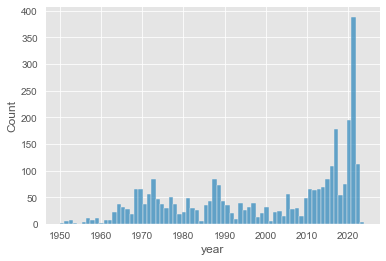

In [31]:
data_full.loc[(data_full.year < 1950) & (data_full.street == 'вокзальная'), 'year'] = 2017
data_full.loc[(data_full.year < 1950) & (data_full.street == 'маршалажукова'), 'year'] = 2021

data_full.loc[((data_full.type == 'Новостройка') & (data_full.year.isnull()) & \
               data_full.description.str.contains('2020')), 'year'] = 2020
data_full.loc[((data_full.type == 'Новостройка') & (data_full.year.isnull()) & \
               data_full.description.str.contains('2021')), 'year'] = 2021
data_full.loc[((data_full.type == 'Новостройка') &  (data_full.year.isnull()) & \
               data_full.description.str.contains('2022')), 'year'] = 2022
data_full.loc[((data_full.type == 'Новостройка') & (data_full.year.isnull()) & \
               data_full.description.str.contains('2023')), 'year'] = 2023

data_full.loc[data_full.year.isnull(), 'year'] = \
data_full[data_full.year.isnull()].apply(find_something, **{'to_find' : 'year'}, axis = 1)

sns.histplot(data_full.year, bins = 70);

Взглянем на распределение общих площадей.

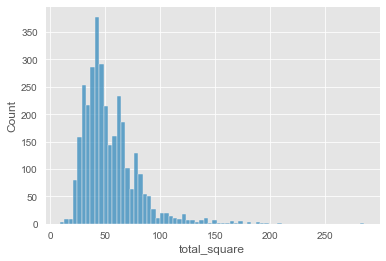

In [32]:
sns.histplot(data_full.total_square, bins = 70);

In [33]:
data_full[data_full.total_square > 250]

id_c      price  floor  max_floor    year      type  total_square  \
804  253756640.0  2250000.0    6.0       12.0  2020.0  Вторичка         286.0   

     kitchen_square  living_square planning  ... parking   consultant  \
804             NaN            NaN      NaN  ...     NaN  Собственник   

               name                                 address  \
804  Студия, 286 м²  Хакасия респ., Абакан, ул. Крылова, 46   

                                           description   street number id_a  \
804  родам 1комнатную квартиру с новым, современным...  крылова     46  NaN   

    court additionally  
804   NaN          NaN  

[1 rows x 30 columns]

Кажется, что однокомнатная квартира в ~270 квадратных метров за 2 млн. руб. - это самая перспективная сделка в истории абаканского рынка недвижимости, избавляемся от нее.

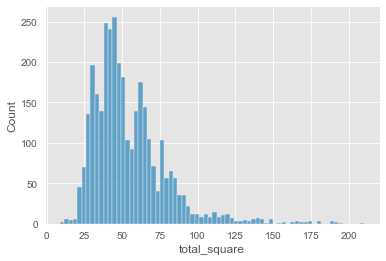

In [34]:
data_full = data_full.drop(data_full[data_full.total_square > 250].index, axis = 0)
sns.histplot(data_full.total_square, bins = 70);

Теперь площадь кухни и жилая площадь. Очень много кухонь по 6 и 9 м², может быть это какой-то стандарт в недвижимости для квартир небольшой площади.

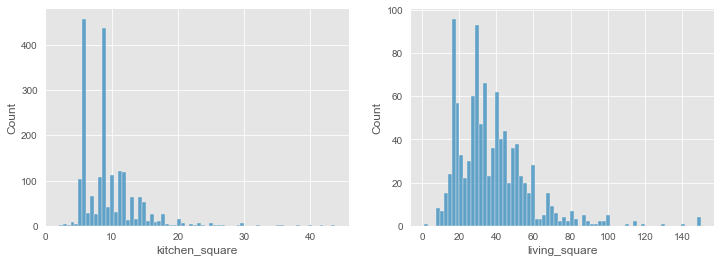

In [35]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
sns.histplot(data_full.kitchen_square, bins = 70, ax = ax[0]);
sns.histplot(data_full.living_square, bins = 70, ax = ax[1]);

Взглянем на квартиры с кухнями более 30 м² и жилыми площадями менее 5 м². Большая часть выглядят правдоподобно, в глаза бросаются только две квартиры: одна с кухней 32 м² и жилой площадью 8 м², здесь, скорее всего, нужно поменять местами, другая с жилой площадью 1 м², тут присвоим *nan*.

In [36]:
data_full[(data_full.living_square < 5) | (data_full.kitchen_square > 30)]

id_c      price  floor  max_floor    year         type  \
351   247722355.0  9000000.0    9.0        9.0  2004.0     Вторичка   
376   250639306.0  2400000.0    2.0        2.0     NaN     Вторичка   
450   254018382.0  7800000.0    5.0        9.0  2005.0     Вторичка   
459   225257884.0  7900000.0    5.0        9.0  2005.0     Вторичка   
513   261004120.0  8200000.0    6.0       12.0  2018.0     Вторичка   
1995  258207791.0  7900000.0    7.0        9.0  1995.0     Вторичка   
2265  248316668.0  4200000.0    7.0        9.0     NaN  Новостройка   
2652          NaN  2350000.0    5.0        5.0  1984.0     Вторичка   
2699          NaN  9500000.0    2.0       12.0  2016.0     Вторичка   
2916          NaN  8000000.0    2.0       10.0  2021.0  Новостройка   

      total_square  kitchen_square  living_square       planning  ...  \
351          143.1            43.8            NaN            NaN  ...   
376           82.0            42.0            NaN            NaN  ...   
450          129.0            35.0            NaN  Изолированная  ...   
459          129.1            35.8           68.4            NaN  ...   
513           88.9            35.0           50.0  Изолированная  ...   
1995         164.0            32.4           94.4        Смежная  ...   
2265          67.9            10.6            1.0            NaN  ...   
2652          47.9            32.0            8.0  Изолированная  ...   
2699         110.0            40.0            NaN            NaN  ...   
2916         110.0            38.0            NaN            NaN  ...   

                parking   consultant                             name  \
351                 NaN        Этажи       3-комн. квартира, 143,1 м²   
376            Наземная  Собственник       4-комн. апартаменты, 82 м²   
450                 NaN        Лидер         3-комн. квартира, 129 м²   
459                 NaN        Этажи       3-комн. квартира, 129,1 м²   
513                 NaN       Глобус        3-комн. квартира, 88,9 м²   
1995                NaN  Собственник         4-комн. квартира, 164 м²   
2265                NaN  Собственник        3-комн. квартира, 67,9 м²   
2652  открытая во дворе  Собственник  2-к. квартира, 47,9 м², 5/5 эт.   
2699                NaN  Собственник  4-к. квартира, 110 м², 2/12 эт.   
2916                NaN  Собственник  3-к. квартира, 110 м², 2/10 эт.   

                                                address  \
351        Хакасия респ., Абакан, просп. Дружбы Народов   
376   Хакасия респ., Абакан, ул. Дружинника Курочкин...   
450         Хакасия респ., Абакан, ул. Карла Маркса, 63   
459             Хакасия респ., Абакан, ул. Карла Маркса   
513              Хакасия респ., Абакан, ул. Кирова, 118   
1995        Хакасия респ., Абакан, ул. Чертыгашева, 126   
2265               Хакасия респ., Абакан, ул. Некрасова   
2652  Республика Хакасия, Абакан, ул. Маршала Жукова...   
2699      Республика Хакасия, Абакан, ул. Кирова, 120к2   
2916                          ул. Маршала Жукова, д. 89   

                                            description               street  \
351   В продаже 3-х комнатная квартира в кирпичном д...        дружбынародов   
376   Квартира состоит из 4х комнатнат: 42 м зал  со...  дружинникакурочкина   
450   ПВХ, с/узел в кафеле, оба балкона застеклены. ...          карламаркса   
459   Огромная 3-хкомнатная квартира площадью около ...          карламаркса   
513   Продается современная просторная трёхкомнатная...               кирова   
1995  Продается элитная двухуровневая четырехкомнатн...          чертыгашева   
2265  В объявлении указан Не тот адрес адрес:  Некра...            некрасова   
2652  Продам 2х комнатную улучшенной планировки квар...        маршалажукова   
2699  Продам 4 комнатную, с двумя с/у, три комнаты и...               кирова   
2916  Продам новую 3-х комнатную квартиру.Комнаты ра...        маршалажукова   

     number          id_a                                  court  \
351       0           Na

In [37]:
data_full.loc[(data_full.kitchen_square == 32) & (data_full.living_square == 8), 'kitchen_square'] = 8
data_full.loc[(data_full.kitchen_square == 32) & (data_full.living_square == 8), 'kitchen_square'] = 32
data_full.loc[(data_full.living_square == 1), 'living_square'] = np.nan

Добиваем потолки. Квартиры с 4 и 4.5 метровыми потолками это, как было сказано ранее, какие-то полутороэтажные помещения, судя по объявлениям. Так как минимальный стандарт потолка - 2.4 метра, так что всему, что меньше, присваиваем *nan*.

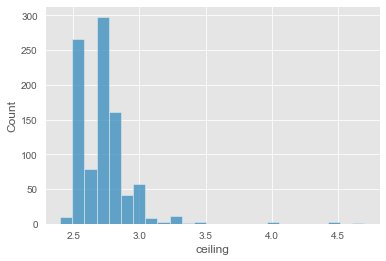

In [38]:
data_full.loc[data_full.ceiling < 2.4, 'ceiling'] = np.nan
data_full.loc[data_full['ceiling'].notnull(), 'ceiling'] = \
data_full.loc[data_full['ceiling'].notnull(), 'ceiling'].astype(np.float64)
sns.histplot(data_full.ceiling, bins = 25);

Про лифты. Согласно найденной информации, на данный момент в каждом доме с количеством этажей **5 и более** должен быть установлен лифт. Тем не менее, если рассматривать именно 5й этаж, то ситуация как будто не однозначна.

In [39]:
data_full[data_full.max_floor == 5].elevator.value_counts()

Нет              258
Есть              55
Есть грузовой     13
Name: elevator, dtype: int64

Больше 5: внимательно посмотрев на предложенные адреса, можно обнаружить, что лифт в этих домах все-таки есть (он, например, указан для них на сайте домклик). Так что прикручиваем им лифт.

In [40]:
data_full.loc[(data_full.max_floor > 5) & ((data_full.elevator == 'Нет') | \
                                           (data_full.elevator.isnull())), 'elevator'] = 'Есть'

Меньше 5: на самом деле в первом доме 5 этажей (информация снова с домклик), в трех остальных квартирах, находящихся в одном доме, 6 этажей. Меняем значения для них в следующем блоке кода.

In [41]:
data_full[(data_full.max_floor < 5) & ((data_full.elevator == 'Есть'))]

id_c      price  floor  max_floor    year      type  \
264   260578645.0  3000000.0    1.0        1.0  1977.0  Вторичка   
1004  259996324.0  3150000.0    2.0        3.0  2014.0  Вторичка   
1005  252754613.0  2900000.0    3.0        3.0  2014.0  Вторичка   
1006  250662021.0  5000000.0    2.0        3.0  2014.0  Вторичка   

      total_square  kitchen_square  living_square       planning  ...  \
264           45.0             6.0           30.0            NaN  ...   
1004          38.0            12.0            NaN            NaN  ...   
1005          32.0             NaN            NaN            NaN  ...   
1006          83.0             9.0            NaN  Изолированная  ...   

                parking   consultant                     name  \
264                 NaN      Жилфонд  2-комн. квартира, 45 м²   
1004  открытая во дворе  Собственник  1-комн. квартира, 38 м²   
1005                NaN  Собственник  1-комн. квартира, 32 м²   
1006  открытая во дворе  Собственник  3-комн. квартира, 83 м²   

                                               address  \
264   Хакасия респ., Абакан, просп. Дружбы Народов, 19   
1004         Хакасия респ., Абакан, ул. Лермонтова, 29   
1005         Хакасия респ., Абакан, ул. Лермонтова, 29   
1006         Хакасия респ., Абакан, ул. Лермонтова, 29   

                                            description         street number  \
264   Продается 2к квартира в центральной части горо...  дружбынародов     19   
1004  В продаже отличная 1 комнатная квартира площад...     лермонтова     29   
1005  Продам квартиру, светлая, уютная со свеже сдел...     лермонтова     29   
1006  Срочно! Продаётся просторная, светлая, трёхком...     лермонтова     29   

              id_a                                  court additionally  
264            NaN                                    NaN          NaN  
1004  2.187348e+09                                    NaN    nannannan  
1005           NaN                                    NaN          NaN  
1006  2.091088e+09  детская площадка, спортивная площадка       nannan  

[4 rows x 30 columns]

Пройдемся по квартирам в домах, где неизвестно наличие/отсутствие лифта, и значению для лифта присвоим наиболее потворяющееся среди домов с таким же адресом (так же, как поступили до этого с годом постройки).

In [42]:
data_full.loc[(data_full.street == 'дружбынародов') & (data_full.number == '19'), 'max_floor'] = 5
data_full.loc[(data_full.street == 'лермонтова') & (data_full.number == '29'), 'max_floor'] = 6
data_full.loc[data_full.max_floor < 5, 'elevator'] = 'Нет'

data_full.loc[data_full.elevator.isnull(), 'elevator'] = \
data_full[data_full.elevator.isnull()].apply(find_something, **{'to_find' : 'elevator'}, axis = 1)

Разделим балконы и лоджии. Затем разделим объявления по типу сделки на собственников и частников.

In [43]:
data_full['logia'] = 0
data_full['logia'] = data_full.balcony.str.split(' ').apply(lambda x: x[2] if len(x) == 4 else 0)
data_full.loc[(data_full.logia == 0) & (data_full.balcony != 'нет'), 'logia'] = \
data_full[(data_full.logia == 0) & (data_full.balcony != 'нет')].balcony.str.split(' ') \
.apply(lambda x: x[0] if ('лодж' in x[1]) else 0)
data_full.logia = data_full.logia.apply(lambda x: np.int64(x))

data_full.loc[data_full.balcony.str.contains('балк') == False, 'balcony'] = 0
data_full.loc[data_full.balcony != 0, 'balcony'] = \
data_full.loc[data_full.balcony != 0, 'balcony'].str.split(' ').apply(lambda x: x[0])
data_full.balcony = data_full.balcony.astype(np.int64)

data_full['private'] = data_full.consultant.apply(lambda x: 0 if x != 'Собственник' else 1)

Заполним тип постройки дома, вид перекрытий и парковки при помощи той же функции **find_something**. Будем считать, что у объявлений, где после этого не появился тип парковки, никакой адекватной парковки возле дома и нет (заполнять наиболее часто встречающимся значением в дальнейшем с таким огромным числом пропусков, по-моему, смысла нет). 

Никаких сталинских домов в Абакане на самом деле нет, удаляем их.

In [44]:
data_full.loc[data_full.building.isnull(), 'building'] = \
data_full[data_full.building.isnull()].apply(find_something, **{'to_find' : 'building'}, axis = 1)

data_full.loc[data_full.overlap.isnull(), 'overlap'] = \
data_full[data_full.overlap.isnull()].apply(find_something, **{'to_find' : 'overlap'}, axis = 1)

data_full.loc[data_full.parking.isnull(), 'parking'] = \
data_full[data_full.parking.isnull()].apply(find_something, **{'to_find' : 'parking'}, axis = 1)
data_full.loc[data_full.parking.isnull(), 'parking'] = 'Без парковки'

data_full.loc[data_full.building == 'сталинский', 'building'] = np.nan

### Дополнительные признаки

Посмотрим на наиболее часто встречающиеся в описании объявлений словосочетания/слова.

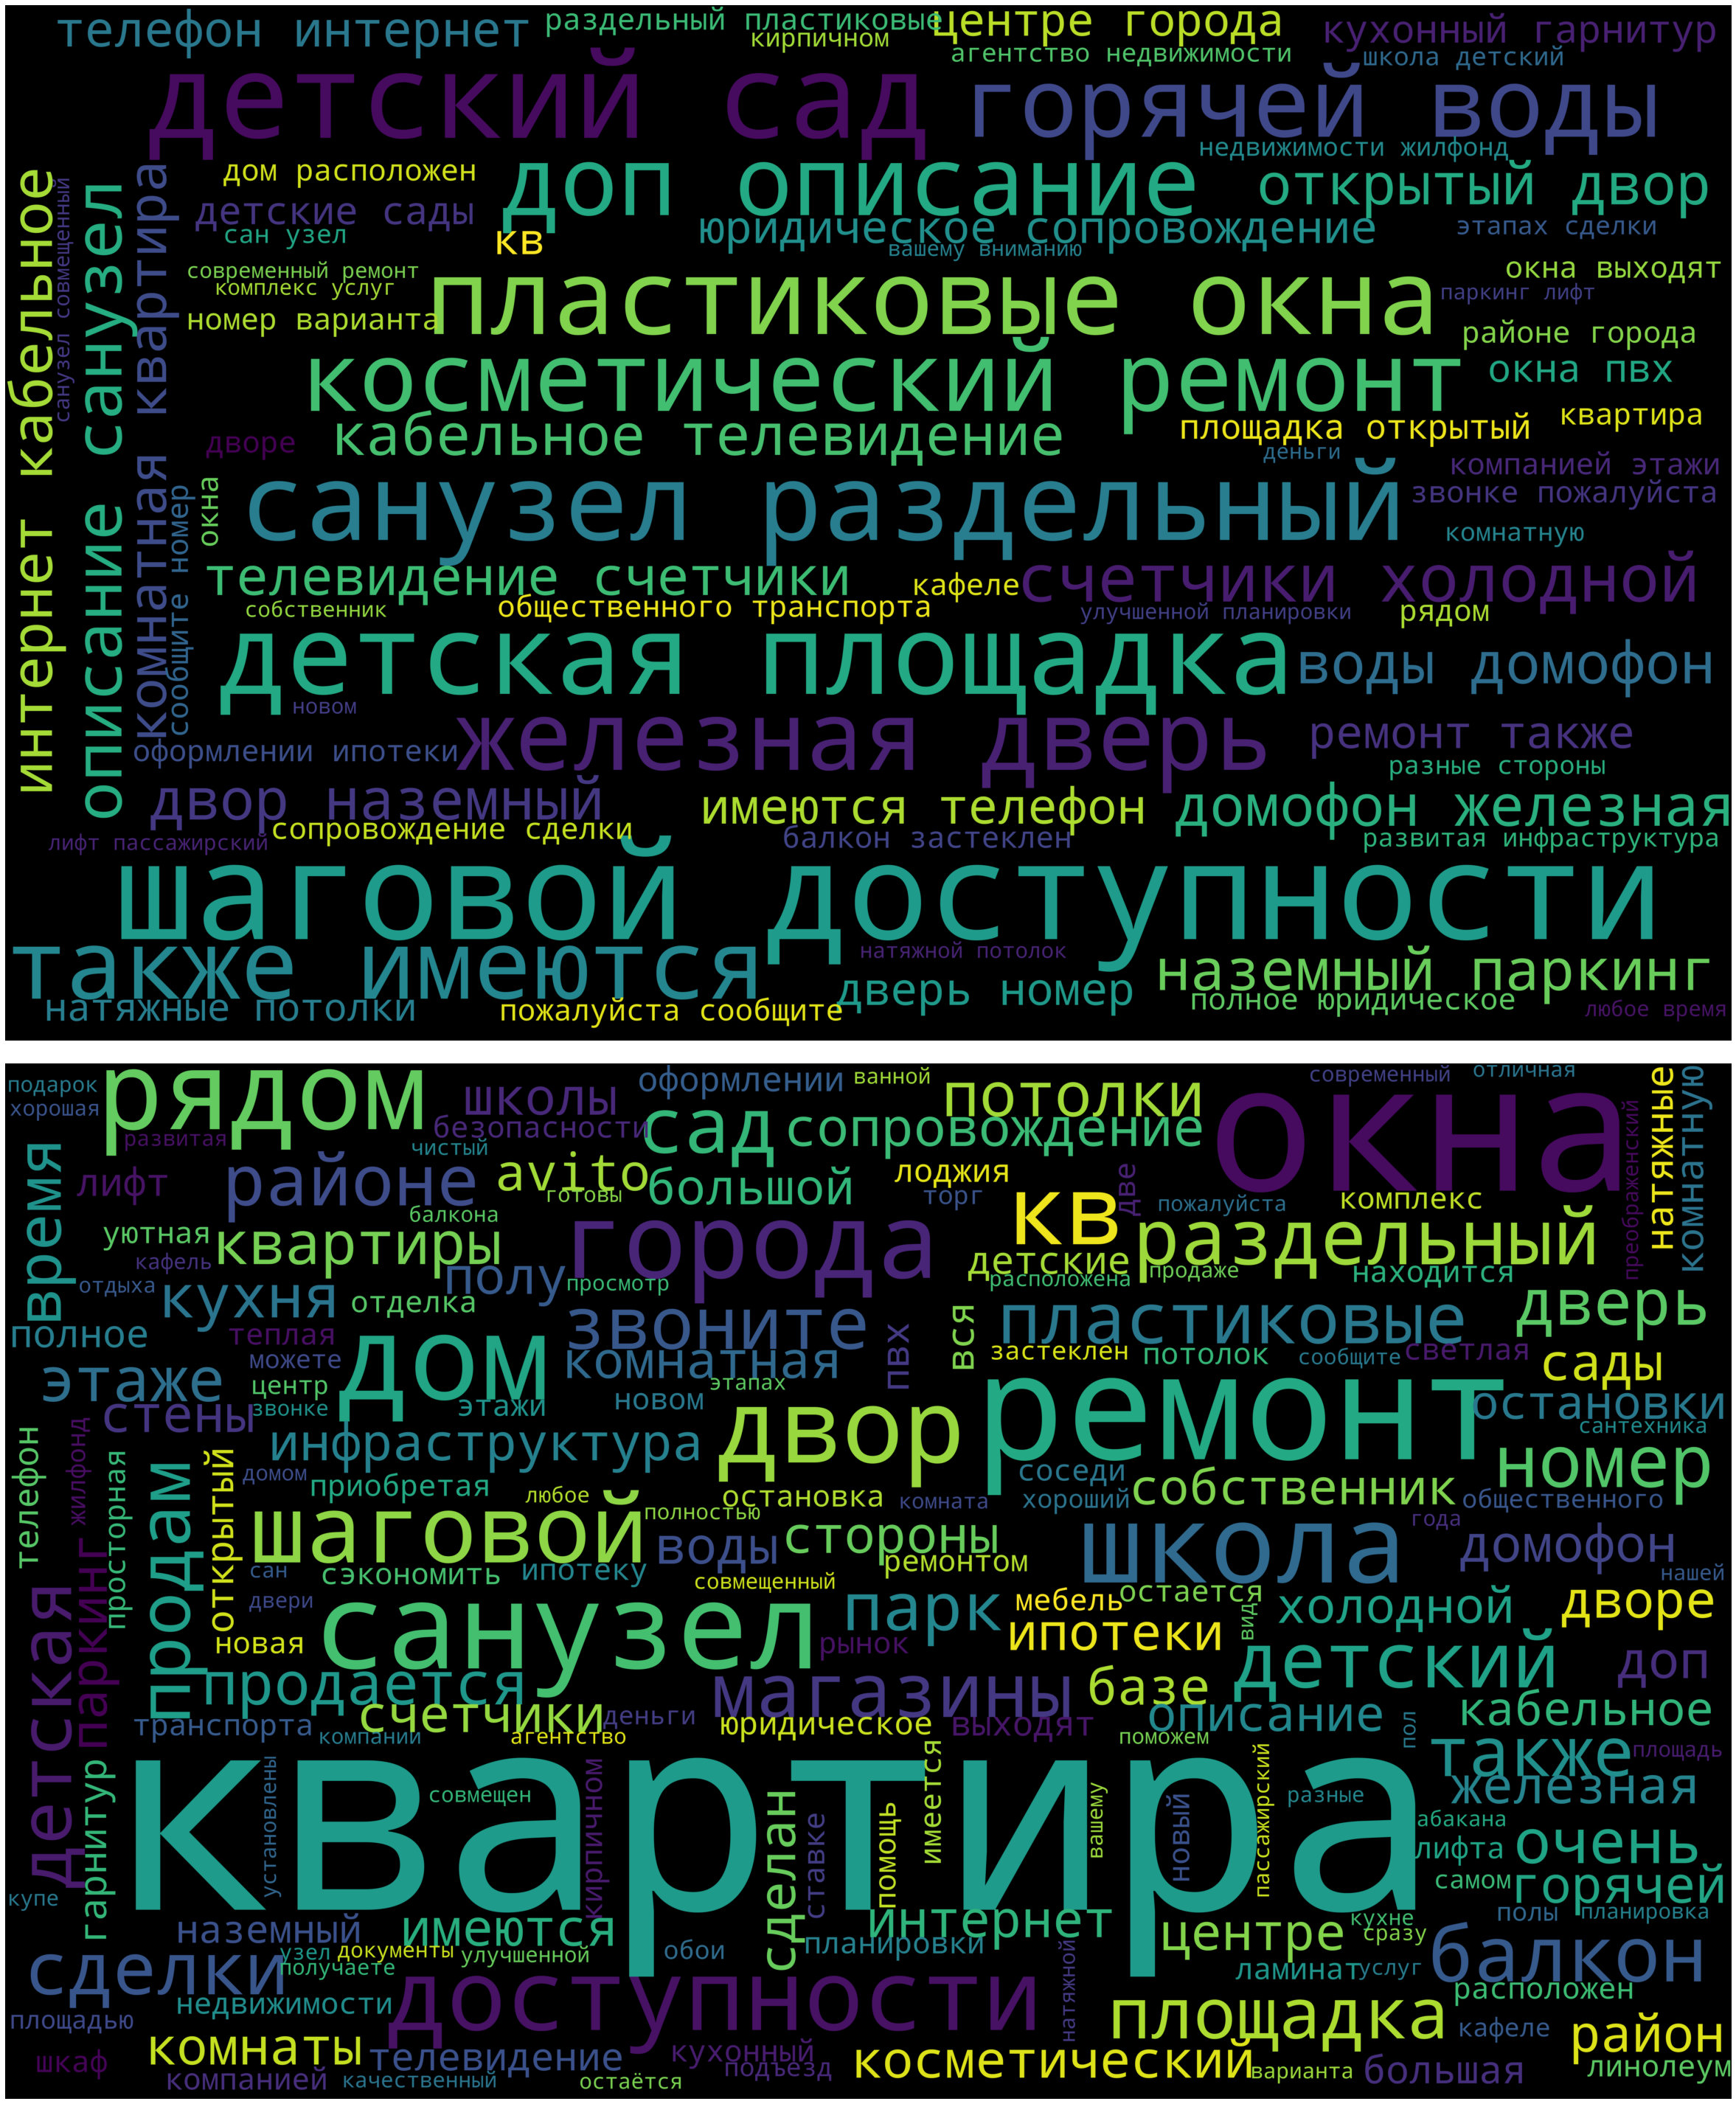

In [45]:
text = ' '.join(data_full['description']).lower() # Словосочетания
text1 = ' '.join(word_tokenize(text)).lower() # Слова
stopw = nltk.corpus.stopwords.words('russian') # Список межометий/словосочетаний/предлогов/прочих неинформативных слов
stopw.extend(['х', 'м', 'квартиру', 'квартире', 'доме', 'дома']) # Немного продлим этот список

wordcloud = WordCloud(width = 800, height = 480, scale = 10, min_font_size = 10, font_step = 2, random_state = 42, \
                      stopwords = stopw, background_color = 'black').generate(text)

wordcloud1 = WordCloud(width = 800, height = 480, scale = 10, min_font_size = 10, font_step = 1, relative_scaling = 1, \
                       background_color = 'black', random_state = 42, collocations = False, stopwords = stopw) \
.generate(text)

fig, ax = plt.subplots(2, 1, figsize = (40, 40))
plt.tight_layout()
ax[0].imshow(wordcloud, interpolation='bilinear', aspect = 'equal');
ax[1].imshow(wordcloud1, interpolation='bilinear', aspect = 'equal');
ax[0].axis('off')
ax[1].axis('off')
plt.show()

В процессе работы над картинками было замечено, что в объявлениях периодически попадаются описания, где рекламодатель пишет о том, что в квартире остается *мебель/кондиционер*. Попробуем создать две новые дамми на то, указано ли в объявлении что-то из перечисленного. 

Для части объявлений из источника **А**  данная информация находится в столбце *additionally*, для остальных будем искать руками в описаниях, сначала посмотрим на то, что именно авторы объявлений с мебелью/без мебели писали в описании к своей квартире.

In [46]:
data_full['furniture'] = data_full.additionally.str.contains('мебель') * 1

data_full[(data_full['furniture'] != 1) & (data_full.description.str.contains('мебел', case = False))].description \
.apply(lambda x: x[x.find('мебел')-20 : x.find('мебел')+8]).unique()

array(['комнатах, остальная мебель п', 'В квартире остается мебель ,',
       'ого проживания, вся мебель и', ' двери, сантехника, мебель. ',
       ' туалете.\nОстальная мебель п', ' выглядит на фото-с мебелью,',
       'емонт, остается вся мебель и', ', можно полностью с мебелью,',
       'ам частично подарят мебель,и', 'ов оставить хорошую мебель (',
       ' кухонный гарнитур, мебель, ', 'монтом по проекту с мебелью ',
       'ётся вся встроенная мебель и', 'тся практически вся мебель.Д',
       'е,частично остается мебель.В', 'вартира продаётся с мебелью ', '',
       'аменена. \nПродажа с мебелью.', 'ртира продается без мебели.\n',
       'бственнику остается мебель и', 'зможен.\n\nЧастично с мебелью ',
       'яжной. Остаётся вся мебель и', 'твенный ремонт: всю мебель, ',
       'артире остается вся мебель и', ' 6360000 - цена без мебели и',
       'анировали в 3-к.) с мебелью ', 'нировки продается с мебелью ',
       ', частично остаётся мебель', 'ерева. На кухне вся мебель ч',

Следующие варианты присвоению квартире статуса *с мебелью* по описанию кажутся наиболее безопасными (отвергающими возможность попадания квартиры *без мебели* в выборку). Постепенно пополняя этот лист, сокращаем количество неотобранных объявлений. Кажется также весьма логичным полагать, что рекламодатель заинтересован в том, чтобы указать наличие мебели в описании, когда квартира продается вместе с ней, так что объявления без упоминания мебели считаем за *немебелированные*.

In [47]:
leave = 'вся мебел|всей мебел|с мебел|вляем мебел|ется мебел|и мебел|ично мебел|, мебел|Вся мебел|Из мебел|из мебел' + \
'|енная мебел|ную мебел|ётся мебел|вить мебел|сю мебел|сть мебел|Мебель ост|мебель ост|ую мебел|ей мебел|ая мебел' + \
'|тью мебел|вим мебел|енной мебел|ейся мебел|ются мебел|,мебел|кой мебел|.Мебел|вой мебел|все мебел|ект мебел' + \
'|аяся мебел|дарят мебел|с  мебел'

# Не смог понять, как одновременно делать и .find(), и .lower(), так что указываю с большой буквы отдельно
data_full.loc[(data_full['furniture'] != 1) & (data_full.description.str.contains(leave)), 'furniture'] = \
((data_full['furniture'] != 1) & (data_full.description.str.contains(leave)) == True)*1

# Откатываем случайно попавшие 'заезжайте, имея мин. набор мебели' и 'за плату оставлю что то из мебели' (sic!)
# Ну и 'с отличной планировкой для расстановки мебели'
data_full.loc[(data_full['furniture'] == 1) & \
          (data_full.description.str.contains('набор мебели.|что то из мебел|расстановки мебел', case = False)),
              'furniture'] = 0
data_full.loc[data_full.furniture.isnull(), 'furniture'] = 0

Повторяем проделанное теперь для кондиционеров.

In [48]:
data_full['aircon'] = data_full.additionally.str.contains('кондиционер') * 1

data_full[(data_full.description.str.contains('конд', case = False))].description \
.apply(lambda x: x[x.find('конд')-30 : x.find('конд')+12]).unique().tolist() + \
data_full[(data_full.description.str.contains('конд', case = False))].description \
.apply(lambda x: x[x.find('Конд')-30 : x.find('Конд')+12]).unique().tolist()

con = 'кондиц|кондец|Кондиц|Кондец'

# Включить 'кондецеонеры', но не включать кондитерские
data_full.loc[(data_full['aircon'] != 1) & (data_full.description.str.contains(con)), 'aircon'] = \
((data_full['aircon'] != 1) & (data_full.description.str.contains(con)) == True) * 1
data_full.loc[data_full.aircon.isnull(), 'aircon'] = 0

На этом очиcтка и обработка данных подходят к концу. Удалось восстановить 600 значений у переменной *year*, 1200 значений у *elevator*, около 200 у *building*, 500 у *overlap*, 1000 у *parking* (без учета замены *nan* на *'нет парковки'*), создать четыре новые переменные: *logia*, *private*, *furniture* и *aircon*. Как можно увидеть на графике ниже, в данных все еще остается много пропущенных переменных, но заполнять их будем с помощью imputer-ов уже на этапе построения моделей.

Насовсем избавимся от переменных *inside*, *additionally*, *planning* и *court*, так как в них слишком много пропусков и слишком мало важной информации (или слишком размытые категориальные значения, или подавляющее большинство строк характеризуется единственной категорией). Вообще хочется выкинуть и *ceiling* с *living_square*, но та как они содержат числовые признаки, можно хотя бы попробовать посмотреть на них в этом аналитическом ноутбуке, но точно не использовать в моделях.

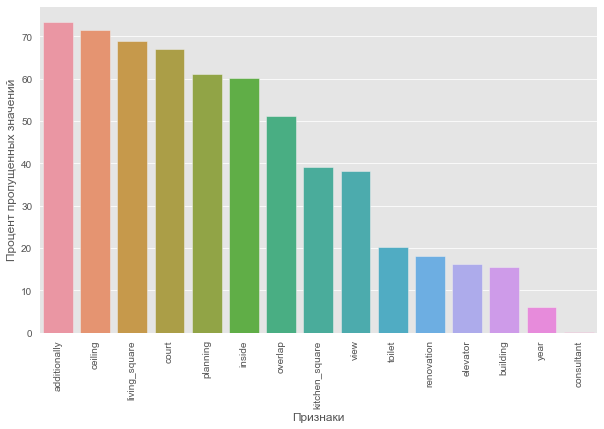

In [49]:
missing = (data_full.isnull().sum() / len(data_full) * 100) \
.drop((data_full.isnull().sum() / len(data_full) * 100)[(data_full.isnull().sum() / len(data_full) * 100) == 0].index) \
.drop(['id_c', 'id_a']).sort_values(ascending = False)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x = missing.index, y = missing);
plt.xlabel('Признаки', fontsize=12);
plt.ylabel('Процент пропущенных значений', fontsize=12);
plt.show()

data_full = data_full.drop(['inside', 'additionally', 'planning', 'court'], axis = 1)

## Визуализации и проверка гипотез

Посмотрим, как цена объявления зависит от потенциально самого главного регрессора в будущих моделях - площади квартиры. Судя по гарфику, зависит весьма линейно. Напоминаю, что  **С** - студия, **К** - квартира свободной планировки, **М** - многокомнатная квартира.

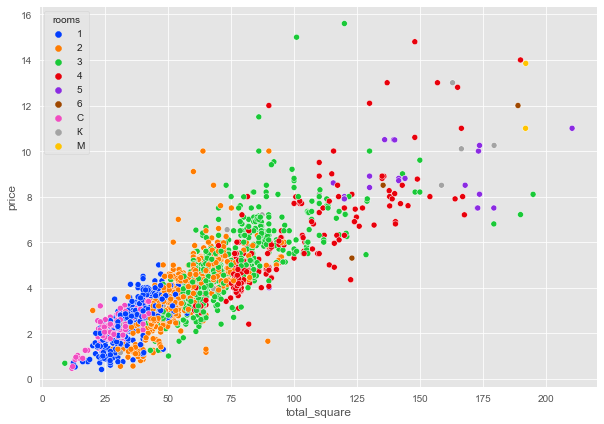

In [50]:
f, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x = data_full.loc[:, 'total_square'], y = data_full.loc[:, 'price']/10**6, hue = data_full.rooms, \
                palette = 'bright', hue_order = [1, 2, 3, 4, 5, 6, 'С', 'К', 'М']);

Теперь для каждой комнатности отдельно. Так как 6-комнатных и многокомнатных квартир всего по 3 и 2 соответственно, а по площади они находятся в одном диапазоне, переведем их в разряд пятикомнатных. 

Еще в данные попала какая-то трешка с площадью меньше 10 м², в описании говорится, что продается комната в коммунальной квартире. Думаю, что предсказание цен комнат нас не очень интересует, быстрый поиск по описаниям выдает только коммунальные услуги, так как коммунальных квартир больше не находится, избавимся от этого объявления.

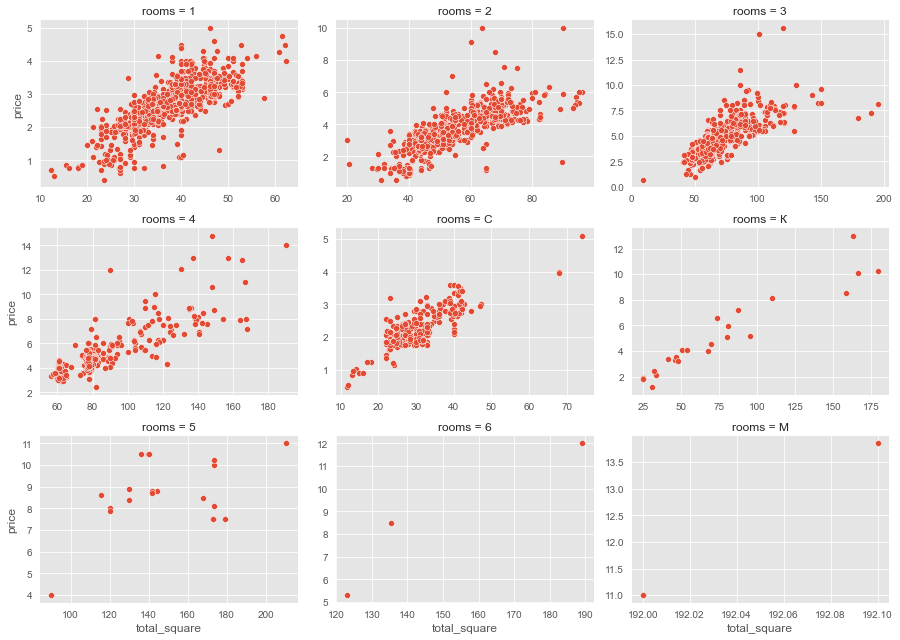

In [51]:
forgrid = data_full.copy()
forgrid.loc[:, 'price'] = forgrid.price/10**6
fig = sns.FacetGrid(data = forgrid, col = 'rooms', col_wrap = 3, sharex = False, sharey = False, aspect = 1.4,\
                    col_order=[1, 2, 3, 4,'С', 'К', 5, 6,'М']) 
fig.map(sns.scatterplot, 'total_square', 'price');

data_full.loc[(data_full.rooms == 6) | (data_full.rooms == 'М'), 'rooms'] = 5
data_full = data_full.drop(data_full[(data_full.rooms == 3) & (data_full.price < 10**6)].index, axis = 0)

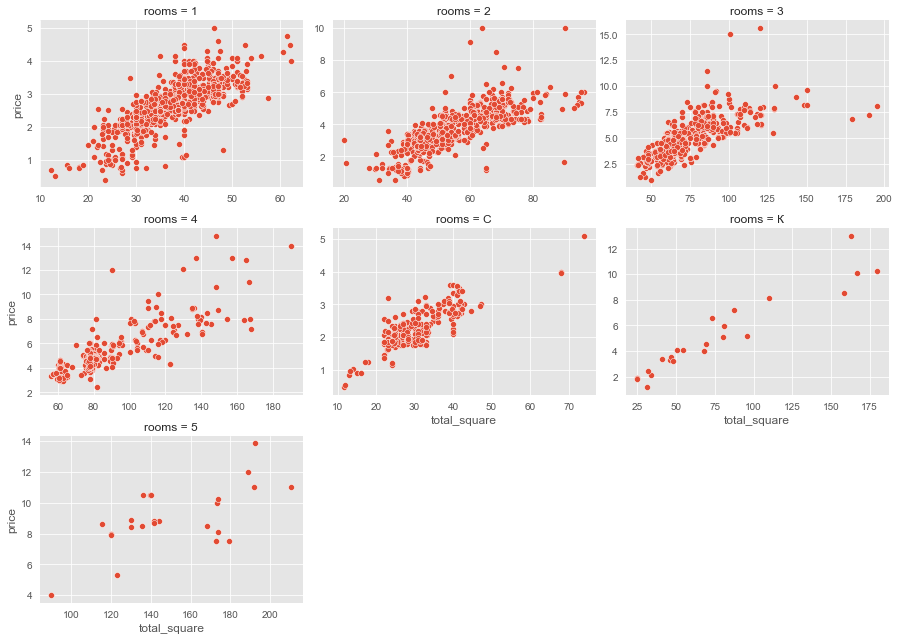

In [52]:
forgrid = data_full.copy()
forgrid.loc[:, 'price'] = forgrid.price/10**6

fig = sns.FacetGrid(data = forgrid, col = 'rooms', col_wrap = 3, sharex = False, sharey = False, aspect = 1.4,\
                    col_order=[1, 2, 3, 4,'С', 'К', 5]) 
fig.map(sns.scatterplot, 'total_square', 'price');

Посмотрим, как цена на квартиру в объявлении распределена по значениям некоторых категориальных переменных. Каких-то ярко выраженных категорий, которые бы разделяли объявления по ценам нет, за исключением части комнат в *rooms* и деревянных зданий в *building*.

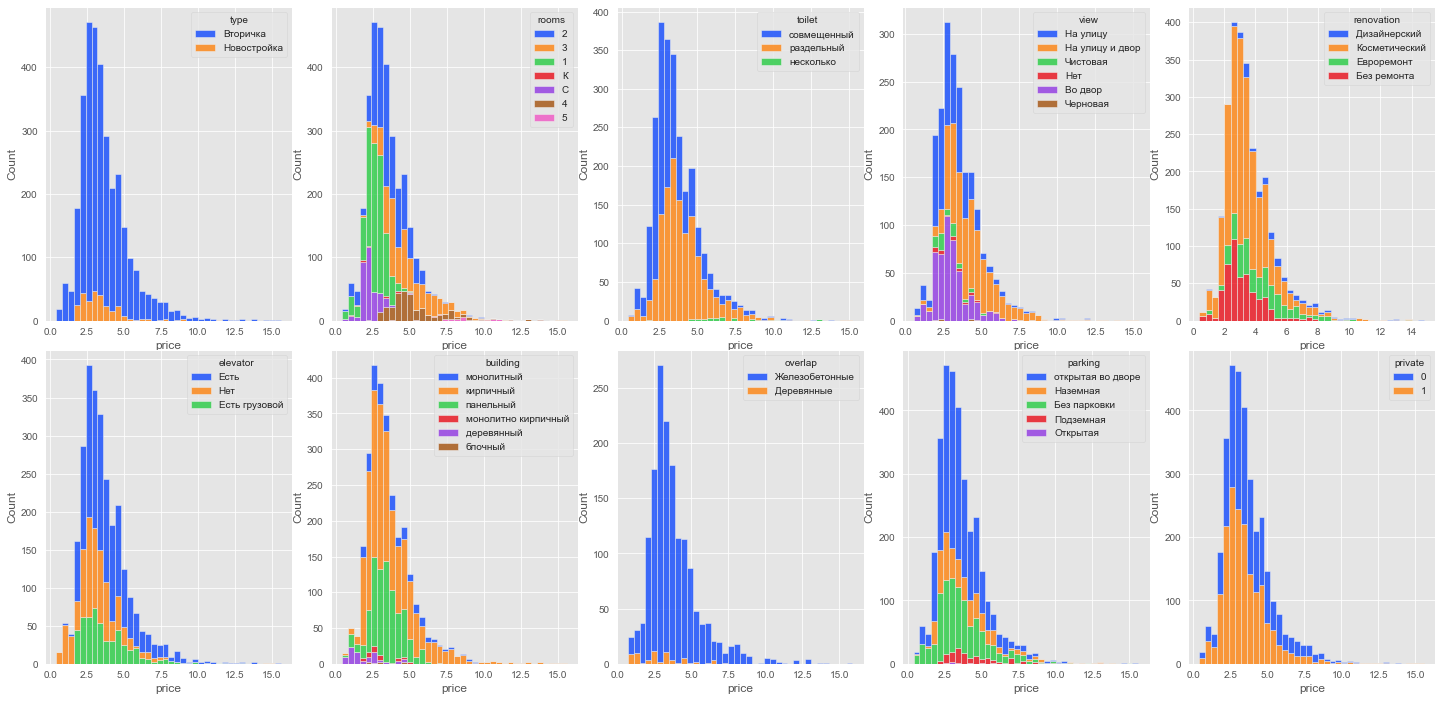

In [53]:
forplott = data_full.loc[:, ['type', 'rooms', 'toilet', 'view', 'renovation',
                              'elevator', 'building', 'overlap', 'parking', 'private']]
multi_plot(5, 2, forplott, data_full.price/10**6, binwidth = 0.4, palette = 'bright', legend = True)

Проверим, как распределены цены в объявлениях (на нормальное распределение, судя по графикам, надеяться не приходится). Логарифмирование слегка улучшает ситуацию, однако до нормального распределния все еще далеко.

In [54]:
print(scipy.stats.anderson(data_full.price), '\n'*2, scipy.stats.anderson(np.log(data_full.price)))

AndersonResult(statistic=84.44278510428285, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ])) 

 AndersonResult(statistic=9.91569149737461, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


Логарифмирование, судя по графикам и статистикам (разница между средним и медианными значениями по выборке меньше), делает распределение цен более симметричным, вместо правого хвоста тяжелее становится левый.

Cредняя цена: 3651304 
Медианная цена: 3300000 
Cтандартное отклонение: 1663139 
Cреднее логарифма цены: 15.0186 
Медиана логарифма цены: 15.0094 
Cтандартное отклонение логарифма цены: 0.432


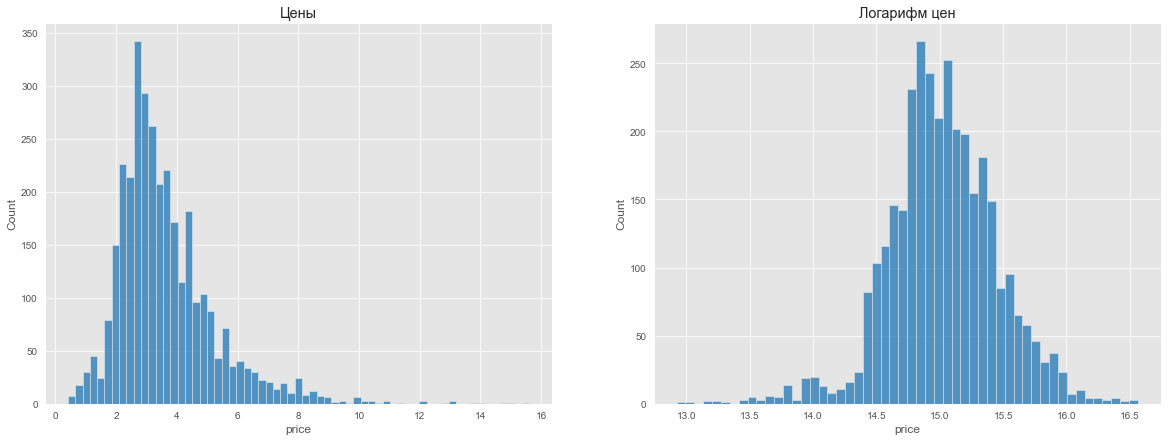

In [55]:
fig, ax = plt.subplots(1, 2, figsize = (20,7))
sns.set_palette('tab10')
sns.histplot(data_full.price/10**6, ax = ax[0]).set_title('Цены');
sns.histplot(np.log(data_full.price), ax = ax[1]).set_title('Логарифм цен');

print('Cредняя цена:', np.int64(data_full.price.mean()), '\n'
      'Медианная цена:', np.int64(data_full.price.median()), '\n'
      'Cтандартное отклонение:', np.int64(data_full.price.std()), '\n'
      'Cреднее логарифма цены:', np.round(np.log(data_full.price).mean(), 4), '\n'
      'Медиана логарифма цены:', np.round(np.log(data_full.price).median(), 4), '\n'
      'Cтандартное отклонение логарифма цены:', np.round(np.log(data_full.price).std(), 4))

Взглянем на распределение цен для каждого из источников объявлений отдельно. Слева **А**, справа **Ц**.

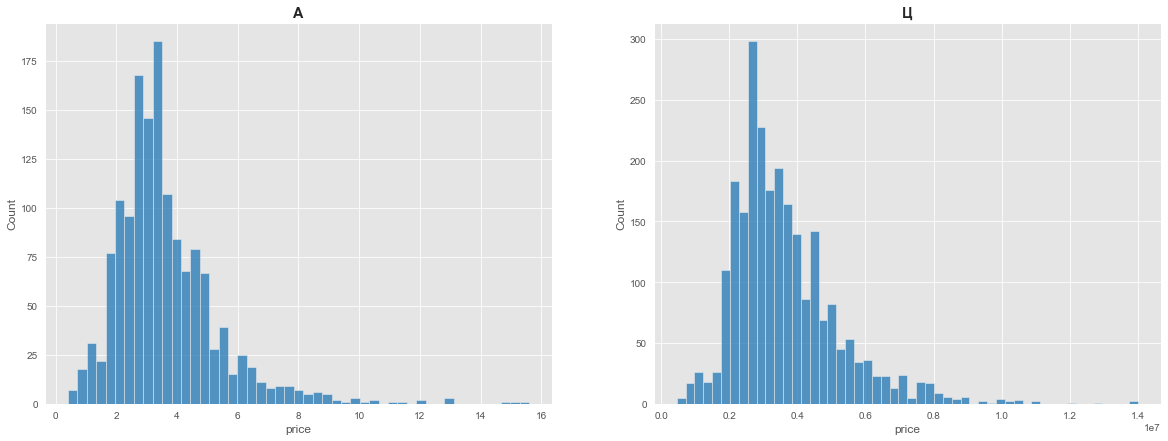

In [56]:
fig, ax = plt.subplots(1, 2, figsize = (20,7))
sns.set_palette('tab10')
sns.histplot(av_data.price/10**6, ax = ax[0]).set_title('А', weight='bold');
# Так как здесь еще не обработанные данные, удаляем выброс
sns.histplot(data.loc[data.price < 30*10**6, 'price'], ax = ax[1]).set_title('Ц', weight='bold'); 

Гипотеза о совпадении функций распределения двух выборок не отвергается.

In [57]:
scipy.stats.ks_2samp(av_data.price, data.loc[data.price < 30*10**6, 'price'])

KstestResult(statistic=0.03712109076022143, pvalue=0.15465342837082696)

Так как гипотеза о нормальности распределения цен объявлений была отвергнута, проверим с помощью *бутстрапа*, как распределено среднее значение цен объявлений. Если гипотеза о нормальности для него не отвергнется, в дальнейшем при тестировании гипотез на ценах можно будет применять *t-test*.

Бутстрапируем выборку 10000 раз, строим probplot и гистограмму, проверяем на нормальность снова с помощью критерия Андерсона. Использование теста Андерсона-Дарлинга здесь вместо Шапиро/Д'Агостино обусловлено тем, что для последних расчет p-value при большом числе наблюдений не всегда может быть верным.

Судя по всему, распределение имеет тяжеловатый правый хвост, но гипотеза о нормальности не отвергается, так что применение критерия Стьюдента вполне обосновано.

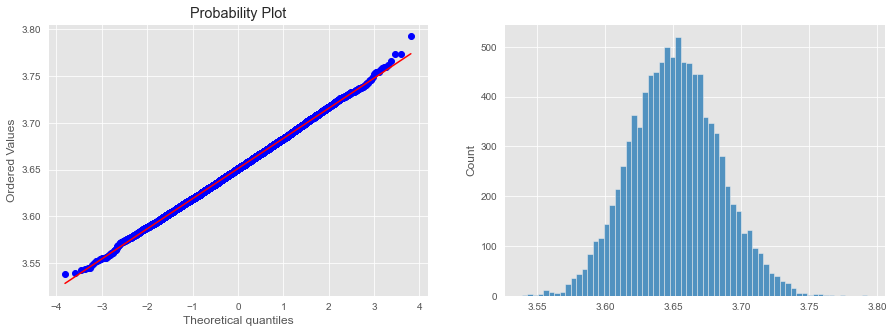

AndersonResult(statistic=0.748952987809389, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [58]:
a = []
for i in range(0, 10000):
    a.append(data_full.price.sample(frac = 0.8, replace = True, random_state = i).mean()/10**6)

fig, ax = plt.subplots(1, 2, figsize = (15,5))
scipy.stats.probplot(a, plot = ax[0]);
sns.histplot(a, ax = ax[1]);
plt.show()

scipy.stats.anderson(a)

Теперь посмотрим на гистограммы трех видов площадей: *общей*, *кухни*, *жилой* и соответствующие гистограммы логарифмов этих площадей. Жилая и общая площадь с логарифмированием выглядят хоть немного лучше, площади кухни уже вряд ли можно помочь.

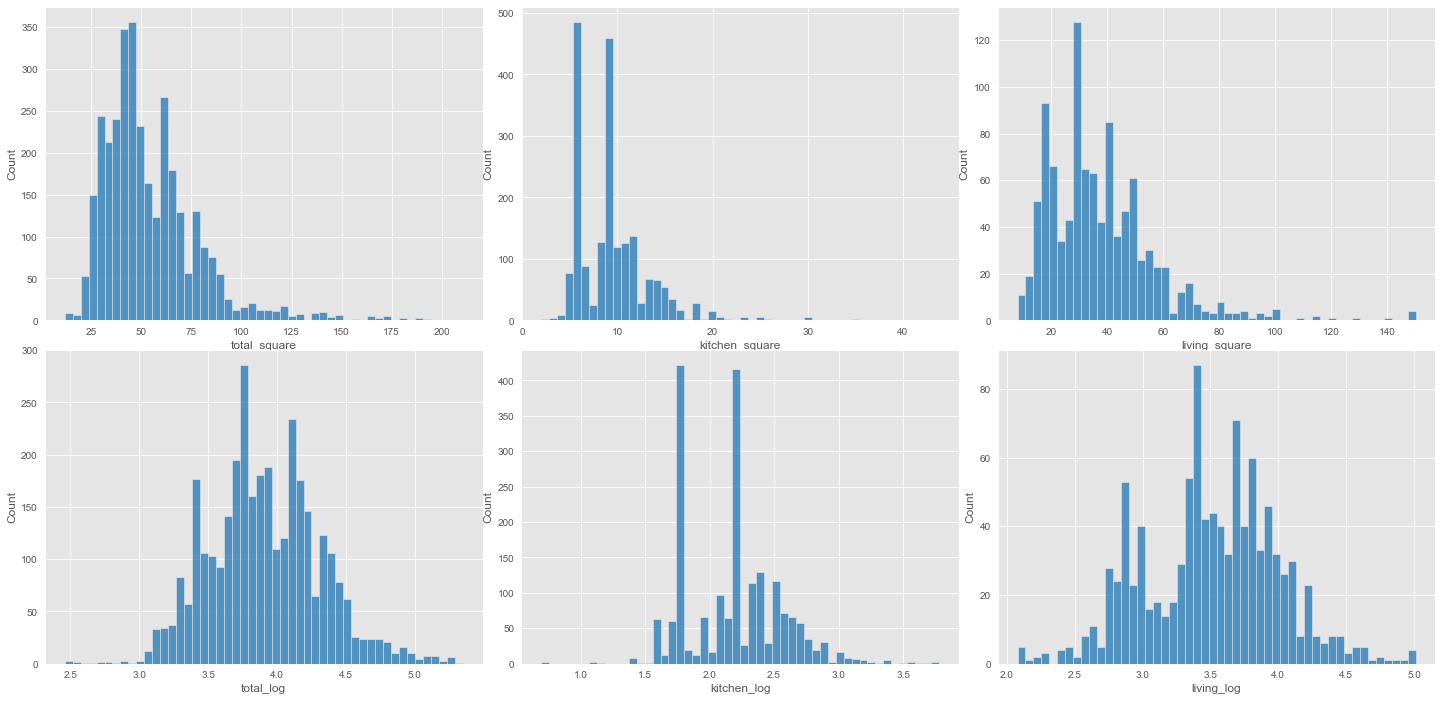

In [59]:
forplott = pd.concat([data_full, pd.DataFrame({'total_log' : np.log(data_full.total_square),
                                    'kitchen_log' : np.log(data_full.kitchen_square),
                                    'living_log' : np.log(data_full.living_square)})], axis = 1)\
.loc[:, ['total_square', 'kitchen_square', 'living_square', 'total_log', 'kitchen_log', 'living_log']]
multi_plot(3, 2, forplott, forplott.columns)

И диаграммы расеяния комбинаций зависимости *цены*/*логарифма цены* от *площадей*/*логарифмов площадей*.

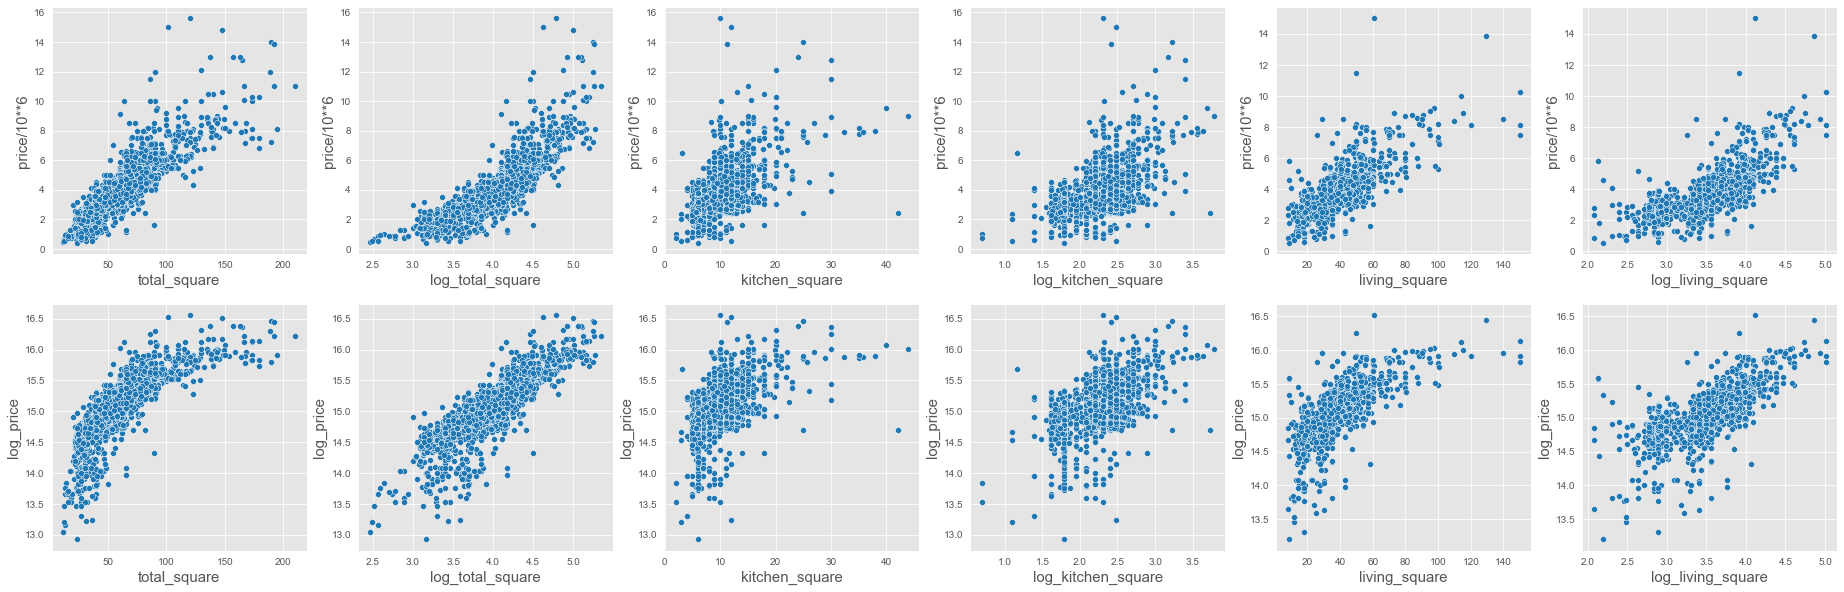

In [60]:
fig, ax = plt.subplots(ncols = 6, nrows = 2, figsize = (32,10))
sns.set_palette('tab10')
i = 0
j = 0
namess = ['', 'log_total_square','', 'log_kitchen_square','', 'log_living_square']
while True:
    if i == 0:
        y_scat = data_full.price/10**6
        ax[i, j].set_ylabel('price/10**6', fontsize = 15)
    else:
        y_scat = np.log(data_full.price)
        ax[i, j].set_ylabel('log_price', fontsize = 15)
    
    if j < 2:
        x_scat = data_full.total_square
        ax[i, j].set_xlabel('total_square', fontsize = 15)
    elif j < 4:
        x_scat = data_full.kitchen_square
        ax[i, j].set_xlabel('kitchen_square', fontsize = 15)
    else:
        x_scat = data_full.living_square 
        ax[i, j].set_xlabel('living_square', fontsize = 15)
    if j % 2 == 1:
        x_scat = np.log(x_scat)
        ax[i, j].set_xlabel(namess[j], fontsize = 15)

        

    sns.scatterplot(x = x_scat, y = y_scat, ax = ax[i, j])
    if j == (6 - 1) and i == (2 - 1):
        break
    elif j < (6 - 1):
        j = j + 1
    else:
        j = 0
        i = i + 1
plt.show()

Нарисуем несколько диаграмм размаха для *цены в объявлении* + *года*/*этажа*/*максимального этажа*/*балкона*/*лоджии*/*высоты потолка*. 

Немного подозрительно выглядят скачки цена в домах ~1956 и ~2003 годов, но ошибок в заполнении я там не нашел, год постройки для них действительно соответствует заявленному. 

Интересен большой размах цен для квартир в доме, где макисмальный этаж равен 15 (медианное значение там максимальное среди всех этажностей), что, скорее всего, связано с тем, что большинство таких домов начали появляться в городе не так давно и являются новостройками.

Для высоты потолков график выглядит не очень адекватно, потому что часть значений слишком редко встречаются в выборке.

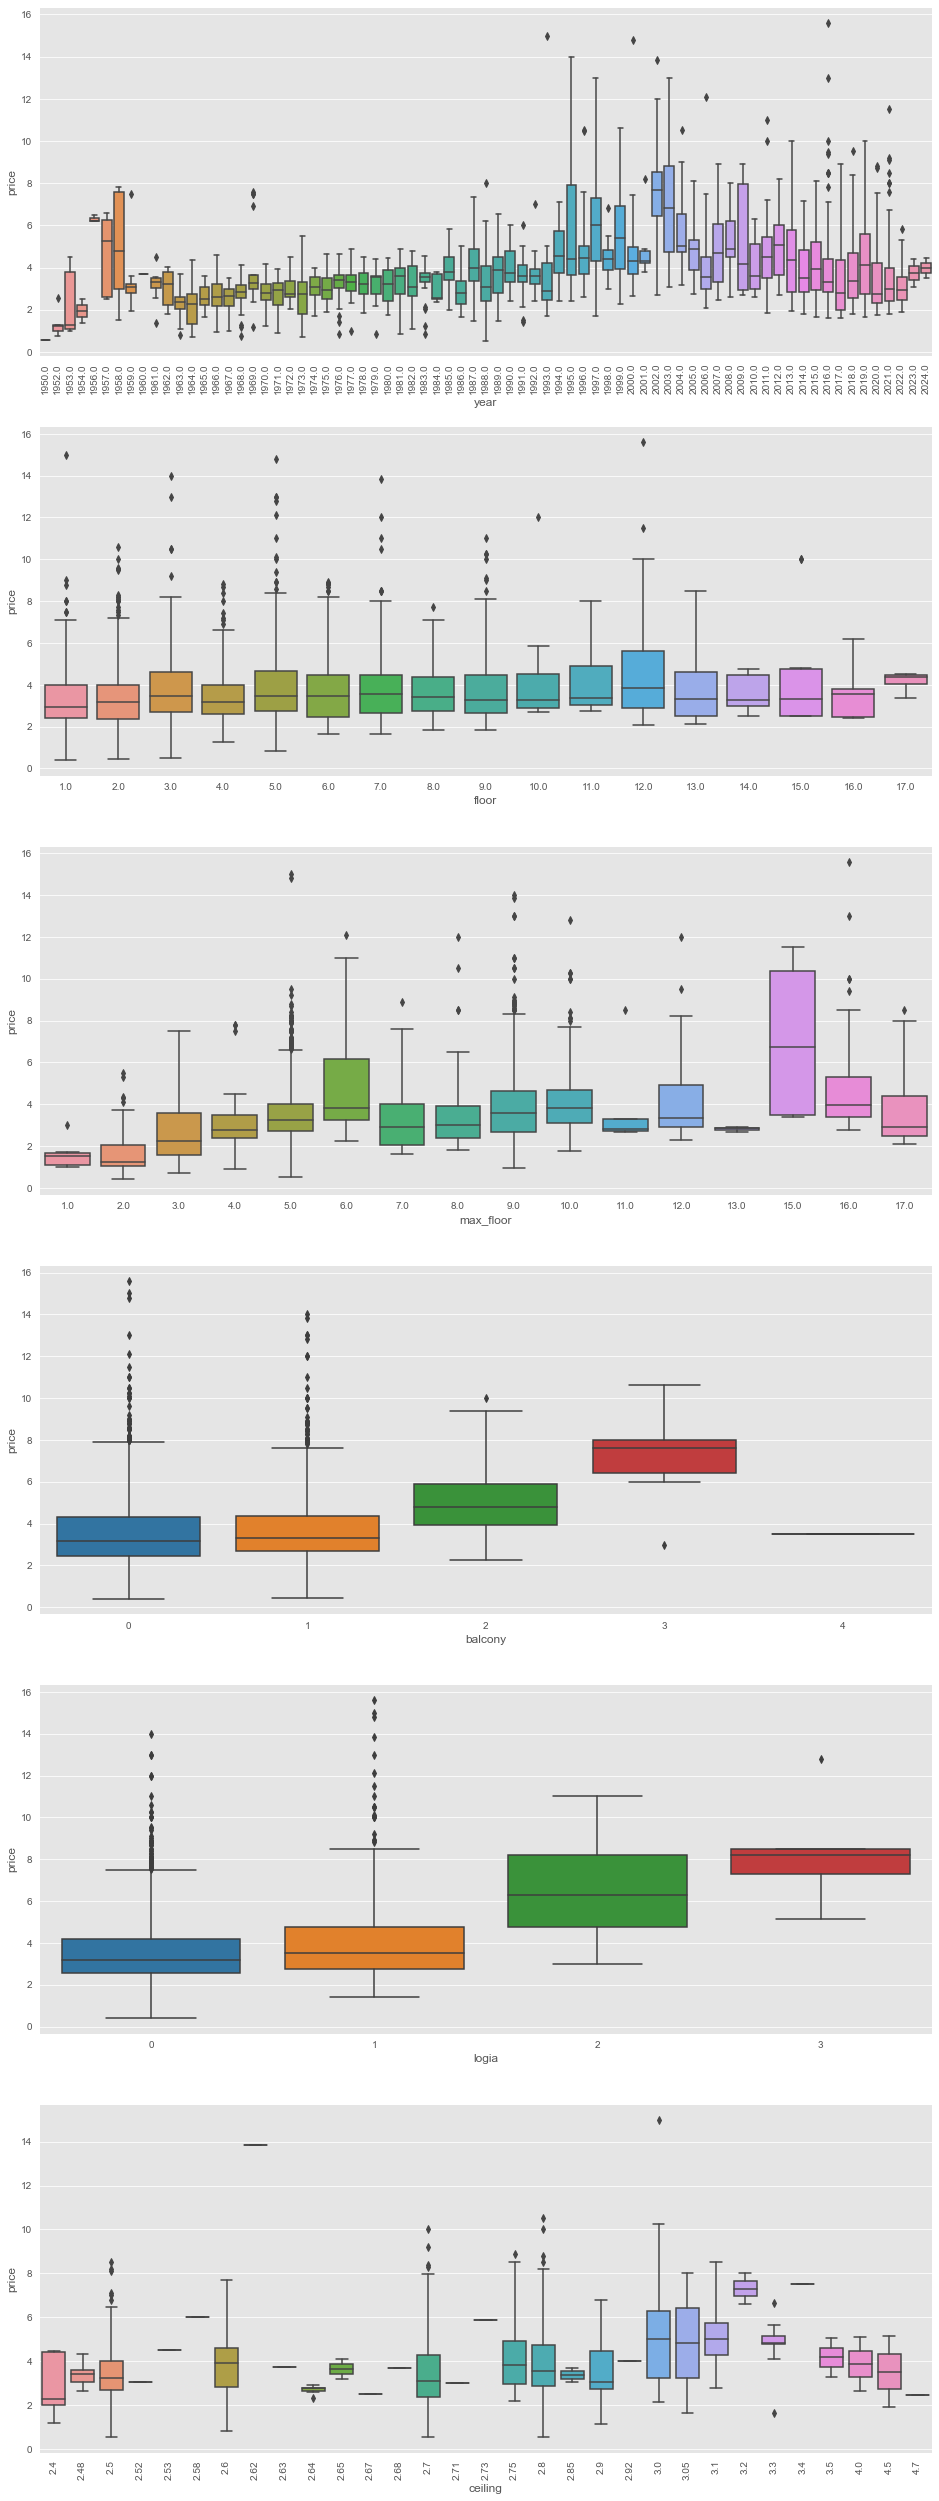

In [61]:
t = 0
fig, ax = plt.subplots(6, 1, figsize=(16, 45))
for i in ['year', 'floor', 'max_floor', 'balcony', 'logia', 'ceiling']:
    sns.boxplot(x = data_full.loc[data_full[i].notnull(), i], y = data_full.price/10**6, whis = 2, ax = ax[t], \
                hue_order = np.sort(data_full.loc[data_full[i].notnull(), i].unique()));
    if t in [0, 5]:
        ax[t].tick_params(axis='x', rotation=90)
    t += 1
plt.show()

Рассмотрим корреляции переменнх. С *ценой*, что неудивительно, сильнее всего коррелируют *площади*, представленные в квартире, коррелирующие и между собой (особенно *общая* и *жилая*). Заметная отрицательная корреляция у числа *балконов* и *лоджий*, что тоже вполне очевидно: если в квартире есть балкон, вряд ли вместе с ним есть и лоджия, и наоборот.

Интересна положительная корреляция между *высотой дома* в этажах и *годом постройки* (с течением времени в Абакане, судя по всему, строились более высокие дома), почему-то с *площадью кухни* немного коррелирует *год постройки* (сейчас строят дома с более просторными кухнями?).

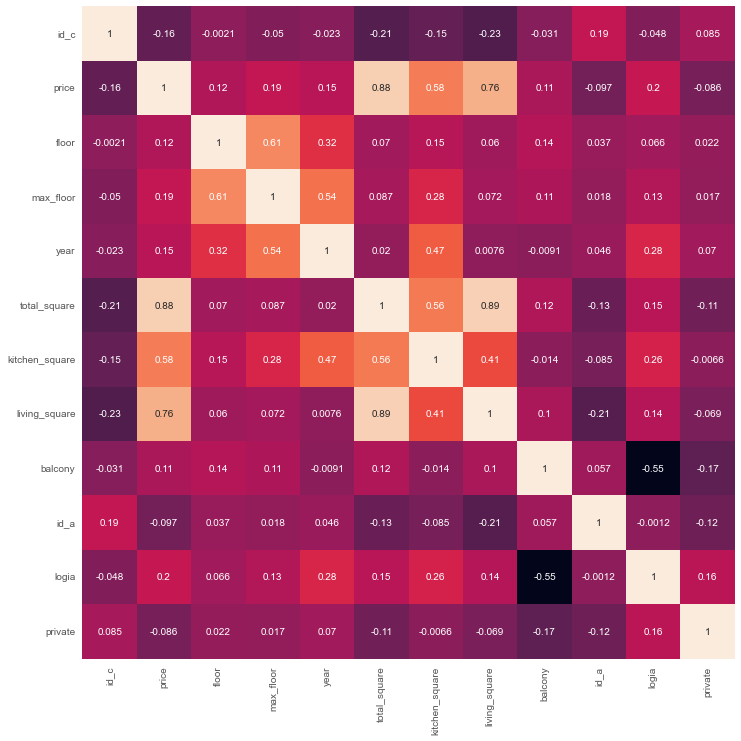

In [62]:
fig, ax = plt.subplots(figsize=(12,12))
fig = sns.heatmap(data_full.corr(), square = True, annot = True, cbar = False);
plt.show()

Для измерения зависимости не только числовых, но и категориальных признаков будем использовать функцию **associations** из модуля **dython**, производящую расчет *корреляции* между числовыми признаками, *Correlation ratio* для пар числовых-категориальных признаков и *Cramer's V* для категориальных-категориальнных пар фичей (почитать можно [здесь](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V) и [здесь](https://en.wikipedia.org/wiki/Correlation_ratio)), *con* в скобках - числовые, *nom* - категориальные.

Тут из интересного: *количество комнат* и *улица* связаны с *ценой объявления*, *тип объявления* (первичка/вторичка) немного коррелирует с *источником объявления* (частник/риэлтор), видимо риэлторы и собственники чаще продают какой-то конкретный вид квартир (какой?).

Забавно, что *номер дома* связан со многими переменными, начиная с *цены*, заканчивая *числом лоджий* в квартире и *типом объявления* (в моделях он, естественно, учитываться не будет, дабы избежать переобучения).

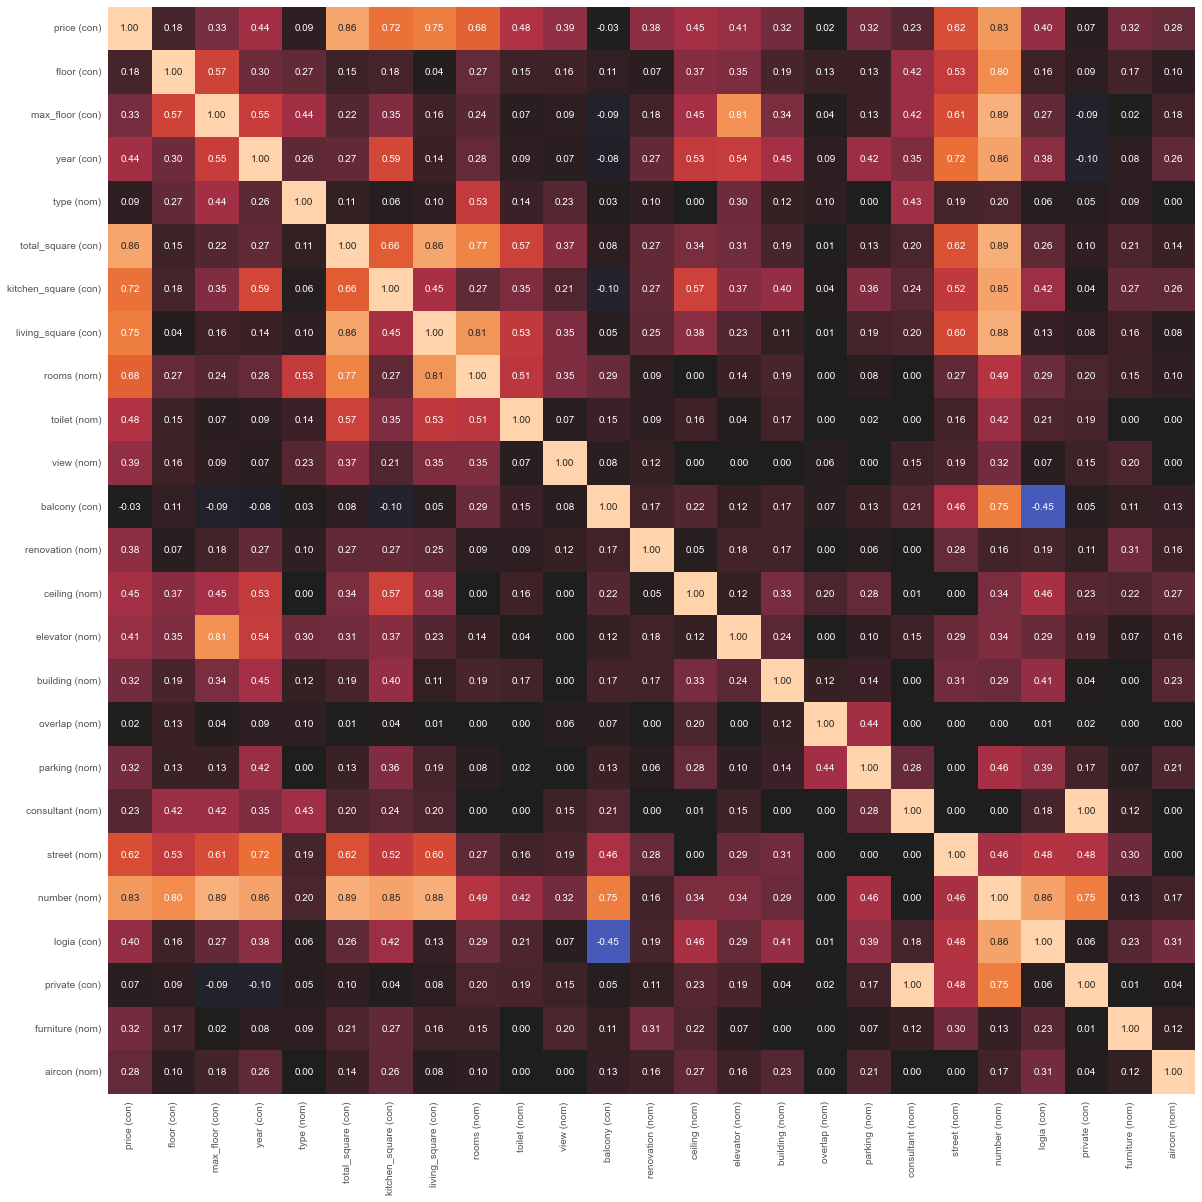

In [63]:
fig, ax = plt.subplots(figsize = (20, 20))
nominal.associations(data_full.drop(['id_c', 'id_a', 'name', 'address', 'description'], axis = 1), \
                     nan_strategy='drop_samples', cbar = False, mark_columns=True, ax=ax)
plt.show()

## Риэлторы

Посмотрим на риэлторские агентства, представляющие большую часть объявлений среди риэлторов на рынке. На правом графике синим - процент объявлений от риэлторов, оранжевым - от частников. Судя по диаграмме, 86.6% объявлений от агентств представляются тремя конторами: **Этажи**, **Жилфонд** и **Лидер**.

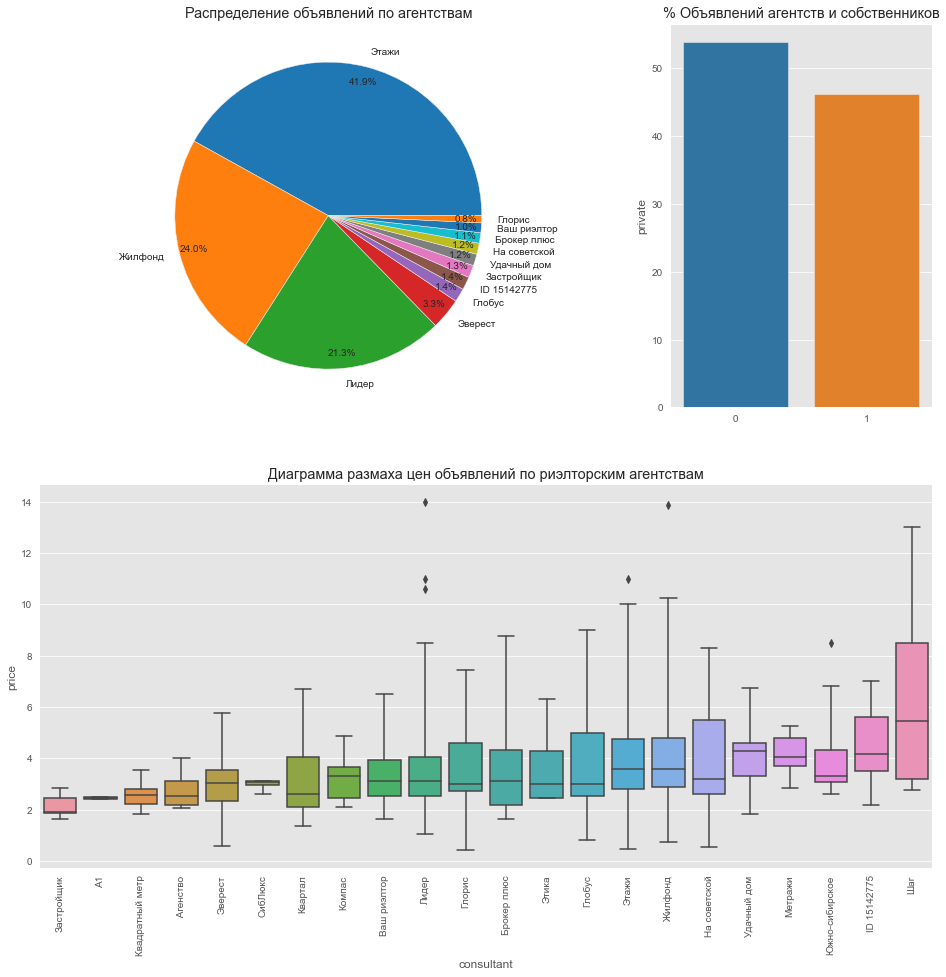

In [64]:
fig = plt.figure()
fig.set_figheight(24)
fig.set_figwidth(16)
ax1 = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
ax2 = plt.subplot2grid(shape=(3, 3), loc=(0, 2), colspan=1)
ax3 = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=4)

pies = data_full.loc[data_full.consultant != 'Собственник', 'consultant'].value_counts() \
[data_full.loc[data_full.consultant != 'Собственник', 'consultant'].value_counts() > 10]

ax1.pie(pies, labels = pies.keys(), autopct = '%1.1f%%', pctdistance = 0.9, labeldistance = 1.1)
ax1.set_title('Распределение объявлений по агентствам')

sns.barplot(x = data_full.private.unique(), y = data_full.private.value_counts()/len(data_full.private)*100, ax = ax2)
ax2.set_title('% Объявлений агентств и собственников')

sns.boxplot(x = data_full.loc[data_full.consultant != 'Собственник', 'consultant'], \
            y = data_full.price/10**6, ax = ax3, whis = 3, \
            order = data_full.groupby('consultant')['price'].agg(lambda x: x.mean()/10**6) \
            .sort_values(ascending = True).drop('Собственник').index);
ax3.tick_params(axis='x', rotation=90)
ax3.set_title('Диаграмма размаха цен объявлений по риэлторским агентствам')

plt.show()

Сначала проверим, существует ли разница в цене между объявлениями риэлторов и частников (альтернативная гипотеза: цены, указанные в объявлениях у риэлторов, выше, чем у собственников). Гипотеза отвергается в пользу альтернативной, тем не менее нельзя точно сказать, что риэлторы завышают цены на объявления, так как могло случиться, что в выборку для них попали на самом деле более дорогие квартиры. 

In [65]:
scipy.stats.ttest_ind(data_full.loc[data_full.private == 0, 'price'], \
                      data_full.loc[data_full.private == 1, 'price'], alternative='greater')

Ttest_indResult(statistic=4.968220078691086, pvalue=3.549927912084036e-07)

Проверим, есть ли разница в ценах на объявления между различными риэлторскими агентствами. Проверять будем для трех основных агентств а также для агентств, которые отвечают хотя бы за **9** объявлений в выборке, кроме трех с наибольшим числом объявлений, это:

In [66]:
data_full.consultant.value_counts()[(data_full.consultant.value_counts() >= 9) & \
                                    (data_full.consultant.value_counts() <= 300)].keys().tolist()

['Эверест',
 'Глобус',
 'ID 15142775',
 'Застройщик',
 'Удачный дом',
 'На советской',
 'Брокер плюс',
 'Ваш риэлтор',
 'Глорис',
 'Шаг',
 'Квартал']

Сначала тестируем на равенство дисперсий при помощи критерия *Левене* (менее чувствителен к ненормальности распределения, в отличие от критерия *Бартлетта*). Гипотезы отвергаются (здесь и далее на уровне значимости 0.05) для обоих тестов, в этом случае не имеет смысла сравнивать все выборки вместе.

In [67]:
print('', scipy.stats.levene(data_full.loc[data_full.consultant == 'Этажи', 'price'], \
                             data_full.loc[data_full.consultant == 'Жилфонд', 'price'], \
                             data_full.loc[data_full.consultant == 'Лидер', 'price']),'\n', \
      scipy.stats.levene(data_full.loc[data_full.consultant == 'Собственник', 'price'], \
                         data_full.loc[data_full.consultant == 'Эверест', 'price'], \
                         data_full.loc[data_full.consultant == 'Глобус', 'price'], \
                         data_full.loc[data_full.consultant == 'ID 15142775', 'price'], \
                         data_full.loc[data_full.consultant == 'Застройщик', 'price'], \
                         data_full.loc[data_full.consultant == 'Удачный дом', 'price'], \
                         data_full.loc[data_full.consultant == 'На советской', 'price'], \
                         data_full.loc[data_full.consultant == 'Брокер плюс', 'price'], \
                         data_full.loc[data_full.consultant == 'Ваш риэлтор', 'price'], \
                         data_full.loc[data_full.consultant == 'Глорис', 'price'], \
                         data_full.loc[data_full.consultant == 'Шаг', 'price'], \
                         data_full.loc[data_full.consultant == 'Квартал', 'price'], \
                         data_full.loc[data_full.consultant == 'Южно-сибирское', 'price']))

 LeveneResult(statistic=3.4558886895237775, pvalue=0.031856582525585875) 
 LeveneResult(statistic=3.617038620406494, pvalue=2.2198098207920223e-05)


Так как гипотеза о равенстве дисперсий была отвергнута, воспользоваться дисперсионным анализом (*ANOVA*) для сравнения цен в выборках нельзя. Вместо него будем использовать *H-критерий Краскела-Уоллиса*. Обе гипотезы отвергаются, проверять гипотезу о равенстве цен для всех групп одновременно снова не имеет смысла. Значит цены в каких-то риэлторских агентствах значимо отличаются друг от друга.

In [68]:
print('', scipy.stats.kruskal(data_full.loc[data_full.consultant == 'Этажи', 'price'], \
                              data_full.loc[data_full.consultant == 'Жилфонд', 'price'], \
                              data_full.loc[data_full.consultant == 'Лидер', 'price']),'\n', \
      scipy.stats.kruskal(data_full.loc[data_full.consultant == 'Собственник', 'price'], \
                          data_full.loc[data_full.consultant == 'Эверест', 'price'], \
                          data_full.loc[data_full.consultant == 'Глобус', 'price'], \
                          data_full.loc[data_full.consultant == 'ID 15142775', 'price'], \
                          data_full.loc[data_full.consultant == 'Застройщик', 'price'], \
                          data_full.loc[data_full.consultant == 'Удачный дом', 'price'], \
                          data_full.loc[data_full.consultant == 'На советской', 'price'], \
                          data_full.loc[data_full.consultant == 'Брокер плюс', 'price'], \
                          data_full.loc[data_full.consultant == 'Ваш риэлтор', 'price'], \
                          data_full.loc[data_full.consultant == 'Глорис', 'price'], \
                          data_full.loc[data_full.consultant == 'Шаг', 'price'], \
                          data_full.loc[data_full.consultant == 'Квартал', 'price'], \
                          data_full.loc[data_full.consultant == 'Южно-сибирское', 'price']))

 KruskalResult(statistic=25.82142476515909, pvalue=2.471433076689555e-06) 
 KruskalResult(statistic=61.46568980581172, pvalue=1.218538251000933e-08)


Взглянем в целом на некоторые статистики по объявлениям от риэлторов (но включим и собственников). Три главных названных ранее конторы продают как низкие по цене квартиры (1 млн.руб. и менее), так и высокие (11 млн.руб +).

In [69]:
data_full.groupby('consultant', as_index = False, sort = True)['price'].agg({'total' : lambda x: x.count(), \
                                                                             'mean' : lambda x: x.mean()/10**6, \
                                                                             'median' : lambda x: x.median()/10**6, \
                                                                             'std' : lambda x: x.std()/10**6, \
                                                                             'min' : lambda x: x.min()/10**6, \
                                                                             'max' : lambda x: x.max()/10**6})

consultant  total      mean  median       std       min        max
0          Агенство      4  2.775000  2.5250  0.876071  2.050000   4.000000
1       ID 15142775     20  4.550250  4.1625  1.419475  2.200000   7.000000
2                А1      3  2.450000  2.4500  0.050000  2.400000   2.500000
3       Брокер плюс     16  3.690344  3.0995  1.983837  1.650000   8.769500
4       Ваш риэлтор     15  3.363266  3.0990  1.250082  1.649999   6.499999
5            Глобус     21  3.835714  3.0000  2.264413  0.800000   9.000000
6            Глорис     11  3.618636  3.0000  1.969007  0.410000   7.450000
7           Жилфонд    350  4.008581  3.6000  1.698110  0.750000  13.850000
8        Застройщик     19  2.102895  1.9200  0.400053  1.622500   2.847000
9   Квадратный метр      8  2.583623  2.5700  0.532078  1.839999   3.550000
10          Квартал      9  3.201389  2.6100  1.672905  1.350000   6.700000
11           Компас      6  3.260000  3.3250  1.022644  2.100000   4.860000
12            Лидер    311  3.520840  3.1000  1.535602  1.060000  14.000000
13          Метражи      6  4.146667  4.0650  0.897478  2.850000   5.250000
14     На советской     17  4.066471  3.2000  1.978127  0.550000   8.300000
15          СибЛюкс      4  2.967500  3.0750  0.232863  2.620000   3.100000
16      Собственник   1782  3.518810  3.2000  1.630075  0.540000  15.600000
17      Удачный дом     18  4.125549  4.3000  1.257025  1.850000   6.741000
18              Шаг      9  6.877778  5.4500  4.014047  2.750000  13.000000
19          Эверест     48  2.951958  3.0250  1.091129  0.599000   5.780000
20            Этажи    611  3.925561  3.6000  1.663703  0.460000  11.000000
21            Этика      5  3.698000  2.9900  1.639289  2.450000   6.300000
22   Южно-сибирское      8  4.245000  3.3000  2.169621  2.620000   8.499999

Сравним каждую из них и собственников попарно. По результатам тестирования получаются весьма интересные выводы:
Цены у **Лидер** значимо отличаются от цен в **Этажи** и **Жилфонд**, а цены между **Жилфонд** и **Этажи** нет, при этом **Лидер** - единственное агенство, цены в котором совпадают с ценами в выборке по собственникам.

Однако, как и ранее, говорить о том, что риэлторы искуственно завышают цены на объявления, нельзя, так как выборка случайная и могло случиться так, что в какие-то из выделенных групп попали более дешевые/дорогие объявления по сравнению с остальными группами.

In [70]:
print(f'H0: Цены в \033[1m"Этажи"\033[0m и \033[1m"Жилфонд"\033[0m совпадают, p_value:', \
      round(scipy.stats.ttest_ind(data_full.loc[data_full.consultant == 'Этажи', 'price'], \
                                  data_full.loc[data_full.consultant == 'Жилфонд', 'price'])[1], 4), '\n'
      f'H0: Цены в \033[1m"Этажи"\033[0m и \033[1m"Лидер"\033[0m совпадают, p_value:', \
      round(scipy.stats.ttest_ind(data_full.loc[data_full.consultant == 'Этажи', 'price'], \
                                  data_full.loc[data_full.consultant == 'Лидер', 'price'])[1], 4),'\n'
      f'H0: Цены в \033[1m"Лидер"\033[0m и \033[1m"Жилфонд"\033[0m совпадают, p_value:', \
      round(scipy.stats.ttest_ind(data_full.loc[data_full.consultant == 'Жилфонд', 'price'], \
                                  data_full.loc[data_full.consultant == 'Лидер', 'price'])[1], 4), '\n'
      f'H0: Цены в \033[1m"Жилфонд"\033[0m и \033[1mЧастники\033[0m совпадают, p_value:', \
      round(scipy.stats.ttest_ind(data_full.loc[data_full.consultant == 'Жилфонд', 'price'], \
                                  data_full.loc[data_full.private == 1, 'price'])[1], 4), '\n'
      f'H0: Цены в \033[1m"Лидер"\033[0m и \033[1mЧастники\033[0m совпадают, p_value:', \
      round(scipy.stats.ttest_ind(data_full.loc[data_full.consultant == 'Лидер', 'price'], \
                                  data_full.loc[data_full.private == 1, 'price'])[1], 4), '\n'
      f'H0: Цены в \033[1m"Этажи"\033[0m и \033[1mЧастники\033[0m совпадают, p_value:', \
      round(scipy.stats.ttest_ind(data_full.loc[data_full.consultant == 'Этажи', 'price'], \
                                  data_full.loc[data_full.private == 1, 'price'])[1], 4))

H0: Цены в "Этажи" и "Жилфонд" совпадают, p_value: 0.4602 
H0: Цены в "Этажи" и "Лидер" совпадают, p_value: 0.0004 
H0: Цены в "Лидер" и "Жилфонд" совпадают, p_value: 0.0001 
H0: Цены в "Жилфонд" и Частники совпадают, p_value: 0.0 
H0: Цены в "Лидер" и Частники совпадают, p_value: 0.9837 
H0: Цены в "Этажи" и Частники совпадают, p_value: 0.0


Напоследок посчитаем немного статистик по улицам.

In [71]:
er = pd.DataFrame(data_full.street)
er['price'] = data_full.price/10**6
er = er.groupby('street', as_index = False)['price'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
er[er['count'] > 5].sort_values('mean', ascending = False)

count      mean   median       std       min        max
street                                                                      
чехова                  44  5.973955  5.02500  3.090296  2.700000  14.800000
карламаркса             44  5.173830  4.35000  2.857746  2.050000  15.000000
торосова               143  4.665946  4.55000  1.499412  2.200000  11.000000
лермонтова              41  4.596683  4.30000  1.533795  2.800000   8.500000
дружбынародов          214  4.450654  3.72500  1.978463  0.850000  13.000000
вяткина                 14  4.308571  3.18000  2.976577  1.650000  10.500000
чертыгашева            128  4.212699  3.53250  2.086600  0.950000  15.600000
аскизская               70  4.175664  3.59000  1.660497  1.450000   8.260000
авиаторов               40  4.110575  3.93750  0.811030  2.900000   6.300000
крылова                160  4.037033  3.80000  1.210915  2.150000   8.000000
ломоносова              20  4.000750  3.80500  1.432561  1.790000   6.100000
стофато                107  3.991625  4.00000  1.381260  1.796000   9.100000
северный                40  3.964600  3.90000  0.931609  2.550000   7.200000
щетинкина               82  3.906457  3.35000  1.533257  1.250000  12.000000
хакасская               38  3.836678  3.63000  1.656446  1.100000   7.990000
вокзальная              21  3.817762  3.30000  1.664840  1.100000   7.100000
кирова                 231  3.746325  3.50000  1.534735  1.250000   9.500000
пушкина                204  3.738466  3.46000  1.555936  0.550000  10.600000
советская               49  3.683673  3.30000  1.732175  0.750000   8.800000
арбан                   64  3.660293  3.25000  1.301799  1.850000   7.990000
катиперекрещенко        44  3.637102  3.35625  1.175262  0.540000   6.800000
ленина                  69  3.624638  3.35000  2.037176  0.520000  12.100000
володарского            15  3.539333  3.30000  0.889209  2.050000   5.100000
комарова               124  3.532081  3.20000  1.252637  1.699000   7.500000
богданахмельницкого     14  3.484571  2.90000  1.452581  2.400000   7.550000
иванаярыгина            72  3.451070  3.00000  0.979084  1.850000   6.100000
трудовая                22  3.400636  3.15500  0.805741  2.699000   5.600000
торговая                54  3.394606  3.36000  1.186513  0.850000   7.100000
ленинскогокомсомола     33  3.307879  2.96000  0.746488  2.110000   4.860000
маршалажукова          135  3.290565  2.90000  1.224126  0.830000   8.300000
дзержинского            34  3.263456  2.91875  1.185354  2.000000   5.600000
красноярская            14  3.245607  3.39950  0.547876  2.300000   3.760000
пирятинская             83  3.163843  3.05000  0.840273  0.890000   6.250000
некрасова              483  3.148103  2.80000  1.455437  1.622500  12.999999
тельмана                32  3.079797  2.67500  1.231204  1.025000   6.999999
островского              9  3.040000  2.99000  0.521249  2.450000   3.900000
кошурникова             28  2.963304  2.85000  0.730424  1.839999   4.400000
тарасашевченко          26  2.770923  2.75000  0.651312  1.950000   5.500000
итыгина                 20  2.755800  2.73250  0.421459  1.960000   3.650000
запорожская              8  2.571250  2.47500  0.310826  2.120000   3.000000
журавлева                8  2.440500  2.31250  0.308939  2.099000   2.800000
герцена                 18  2.292500  2.37000  0.654636  1.000000   3.270000
буденного               48  2.268500  2.22500  0.841412  0.700000   4.500000
минусинская              9  2.197556  2.40000  0.647992  1.050000   2.750000
луначарского             8  2.112500  1.92500  0.677047  1.200000   3.350000
мичурина                 7  2.084856  1.69500  1.070468  0.599000   3.600000
гагарина                14  2.062405  1.52500  1.322633  0.460000   4.475000
согринская              14  1.964375  1.80000  0.444007  1.474500   3.100000
совхозная               10  1.468900  1.23950  0.548358  0.800000   2.500000
котовского               6  1.245833  1.22000  0.120101  1.150000   1.470000
молодежныйквартал

10 улиц с наибольшим количеством объявлений выглядят следующим образом.

In [72]:
er.sort_values('count', ascending = False).head(10)

count      mean  median       std     min        max
street                                                             
некрасова        483  3.148103  2.8000  1.455437  1.6225  12.999999
кирова           231  3.746325  3.5000  1.534735  1.2500   9.500000
дружбынародов    214  4.450654  3.7250  1.978463  0.8500  13.000000
пушкина          204  3.738466  3.4600  1.555936  0.5500  10.600000
крылова          160  4.037033  3.8000  1.210915  2.1500   8.000000
торосова         143  4.665946  4.5500  1.499412  2.2000  11.000000
маршалажукова    135  3.290565  2.9000  1.224126  0.8300   8.300000
чертыгашева      128  4.212699  3.5325  2.086600  0.9500  15.600000
комарова         124  3.532081  3.2000  1.252637  1.6990   7.500000
стофато          107  3.991625  4.0000  1.381260  1.7960   9.100000

## Результат

На выход имеем объединенный датасет с очищенными объявлениями о продаже квартир в Абакане в 3309 строчек и 30 колонок.

In [73]:
data_full.info()
data_full.reset_index(drop = True).to_csv('data2.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3309 entries, 0 to 3312
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_c            2403 non-null   float64
 1   price           3309 non-null   float64
 2   floor           3309 non-null   float64
 3   max_floor       3309 non-null   float64
 4   year            3112 non-null   float64
 5   type            3309 non-null   object 
 6   total_square    3309 non-null   float64
 7   kitchen_square  2018 non-null   float64
 8   living_square   1030 non-null   float64
 9   rooms           3309 non-null   object 
 10  toilet          2641 non-null   object 
 11  view            2049 non-null   object 
 12  balcony         3309 non-null   int64  
 13  renovation      2709 non-null   object 
 14  ceiling         942 non-null    object 
 15  elevator        2775 non-null   object 
 16  building        2799 non-null   object 
 17  overlap         1615 non-null   o

## Чего не хватает этому ноутбуку

* Пайплайна. Было бы здорово автоматизировать процессы очистки, приведения данных к одному формату, поадресного заполнения пропусков, удаления выбросов, построения графиков и проверки гипотез, так как когда-нибудь может появиться дополнительная выборка, которую точно так же придется обрабатывать заново, и запускать для этого поочередно чанки в ноутбуке уже совсем не круто. Но я не очень представляю, как это можно сделать. Используемый здесь подход предполагает следующую схему работы с данными: 
1. **Посмотреть на аномалии**  
2. **Найти ошибки**
3. **Перейти по id объявлений на их страницы**/**найти информацию о возможных вопросах (обычно касательно стандартов недвижимости) в интернете**
3. **На основании сведений из предыдущего пункта попытаться логически решить возникшую проблему**

    В случае, когда весь описанный процесс нужно решить одним скриптом, очевидно, что 2 и 3 пункты реализовать практически нереально. Тогда спорные объявления, информация в которых обычно легко проверяется ручками, придется просто выкидывать из выборки, что к концу процесса может ее значительно сократить (когда в выборке 3300 наблюдений, хочется сильно бороться за то, чтобы оставить каждое из них). А неизбежно появляющиеся новые ошибки (например, какие-то категории комнат, которых не было раньше, неверно заполненные описания, корявые адреса и еще куча всего) будут бесконечно ломать код, а в худшем случае просто передавать на следующие шаги неправильные результаты, которые не легко будет моментально заметить и починить. В общем, автоматизация всего процесса тянет на отдельный пет-проект, часть которого, тем не менее, безусловно можно удачно реализовать и здесь (например, подход с заполнением информации о доме по совпадающим адресам, или базовый EDA и т.д.).
    
* Улучшения схемы поиска одинаковых объявлений с разных платформ. Здесь можно попробовать как сравнивать самые разные признаки у объявлений и самое разное их количество, в том числе попробовать найти оптимальную разницу цен объявлений, при которой они будут считаться одинаковыми (я выбирал между 100 000, 50 000 и 150 000 и показалось, что для 100 000 находятся почти все совпадения), так и придумать что-то поинтереснее, например искать одинаковые объявления по каким-нибудь фразам в описании.


* Анализа текстового описания объявлений. Тут вообще широченный простор для решения тру nlp задачи. Помимо тех базовых признаков (кондиционер и мебель), что смог выудить из описаний я при помощи самого базового поиска по ключевым словам, кажется, что здесь можно попробовать очень много всего. Начиная от какой-то комбинации word2vec + tf-idf, заканчивая нейросетевыми подходами. Смущает, конечно же, тот факт, что данных не так много, именно поэтому я не стал углубляться в анализ описаний, боясь безрезультатно убить много времени, но в дальнейшем может быть решусь попробовать (стоит заметить, что если добывать вместе со строковыми переменными еще и фотографии квартир, то потенциально можно прикрутить и cv, скорее всего, есть статьи, где что-то такое уже пробовали для объявлений, нужно посмотреть на применяемые подходы и результат).